___

<a href='http://www.dourthe.tech'> <img src='Dourthe_Technologies_Headers.png' /></a>
___
<center><em>For more information, visit <a href='http://www.dourthe.tech'>www.dourthe.tech</a></em></center>

# Multi-Organ Image Segmentation using Multi-Scale Pyramid 3D Fully Convolutional Network

___ 
## Objective
Implement a multi-scale pyramid V-shaped 3D Fully Convolutional Network (FCN) architecture enabling the automated segmentation of multiple organs from CT images.

___
## Google Colab
Since this project requires GPU acceleration, a similar version of this notebook was created for Google Colab.

Please check the notebook _(Colab) Multi Organ Image Segmentation using Multi-Scale Pyramid 3D FCN.ipynb_ for more details.

___
## Dataset
The dataset was downloaded from the Multi-Atlas Labeling Beyond the Cranial Vault Challenge: https://www.synapse.org/#!Synapse:syn3193805/wiki/217752

More specifically, the dataset contains a total of 50 CT scans of the abdomen collected under Institutional Review Board supervision across the Vanderbilt University Medical Center (Nashville, TN, USA).

### CT scans parameters
Since all CT scans were randomly selected from a combination of trials and studies, the scanning parameters varies slightly between scans:

| Parameter | Range | Unit | 
|:---|:---|:---|
| Volume | (512 x 512 x 85) - (512 - 512 - 198) | _pixels_ |
| Field of view | (280 x 280 x 280) - (500 x 500 x 650) | _mm3_ |
| In-plane resolution | (0.54 x 0.54) - (0.98 x 0.98) | _mm2_ |
| Slice thickness | 2.5 - 5.0 | _mm_ |

### Data labeling
A total of 13 organs were manually segmented by trained raters and reviewed for label accuracy by a radiologist or radiation oncologist.

![png](img/abdomen_overview_small.png)

**NOTE:** For patients who did not have a right kidney or a gallbladder, the corresponding labels were not included in the resulting labeled file.

For more details, visit: https://www.synapse.org/#!Synapse:syn3193805/wiki/217789

### Data structure
All image and label files are stored in a compressed (.gz) Nifti (.nii) file format (e.g. img0001.nii.gz) that can be read using the SimpleITK library and will result in a (m x n x l) array where:
- m = number of frames/slices
- n = image width (in pixels)
- l = image height (in pixels)
For every image file, the numerical values stored in each (n x l) frame represents a grayscale value.

For every label file, the numerical values stored in each (n x l) frame represents the label of the corresponding organ:
0. background/other
1. spleen
2. right kidney
3. left kidney
4. gallbladder
5. esophagus
6. liver
7. stomach
8. aorta
9. inferior vena cava
10. portal vein and splenic vein
11. pancreas
12. right adrenal gland
13. left adrenal gland

For instance, if on frame X at position (Y, Z) the corresponding pixel has a value of 7, this pixel belongs to the stomach.

**NOTE:** The .gz files DO NOT need to be extracted, as they can be directly imported and read using the SimpleITK library.

### Training/Testing
Since the dataset was released as part of a challenge, the dataset was divided into a training (30 CT scans) and testing (20 CT scans) set, where only the training labels were provided. The testing labels were kept by the institution for internal evaluation.

**As a result, for local model evaluation, the work presented below will be using 80% of the available labeled data (i.e. 24 CT scans) as a training set and the remaining 20% (i.e. 6 CT scans) as a validation set.**

### Data management
The data were re-organized using the following data structure:

<pre>
└─ data
   ├── raw
   │   ├── test
   │   │   ├── img (6 files)
   │   │   │   ├── img0035.nii.gz
   │   │   │   ├── ... 
   │   │   │   └── img0040.nii.gz
   │   │   │
   │   │   └── label (6 files)
   │   │       ├── label0035.nii.gz
   │   │       ├── ... 
   │   │       └── label0040.nii.gz     
   │   │           
   │   └── train
   │       ├── img (24 files)
   │       │   ├── img0001.nii.gz
   │       │   ├── ... 
   │       │   └── img0034.nii.gz
   │       │
   │       └── label (24 files)
   │           ├── label0001.nii.gz
   │           ├── ... 
   │           └── label0034.nii.gz
   │
   └── processed (data will only appear after running the corresponding pre-processing script)
       ├── test
       │   ├── img (6 files)
       │   │   ├── img0035.nii
       │   │   ├── ... 
       │   │   └── img0040.nii
       │   │
       │   └── label (6 files)
       │       ├── label0035.nii
       │       ├── ... 
       │       └── label0040.nii     
       │           
       └── train
           ├── img (24 files)
           │   ├── img0001.nii
           │   ├── ... 
           │   └── img0034.nii
           │
           └── label (24 files)
               ├── label0001.nii
               ├── ... 
               └── label0034.nii</pre>

___
# Libraries Import

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# System characteristics
import psutil
import humanize
import GPUtil as GPU

# Computation time monitoring
from time import time

# Data visualization
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Data processing
import os
import math
import shutil
import pandas as pd
import numpy as np
import xlsxwriter as xw
import SimpleITK as sitk
from scipy import ndimage
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from collections import OrderedDict

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F

___
# System Characteristics

## Check system informations and GPU

In [2]:
# Display local virtual memory (RAM)
print(f'\033[1mRAM Memory:\t\033[0m{humanize.naturalsize(psutil.virtual_memory().available)} (Available)\n')

# Check if GPU is enabled
print(f'\033[1mGPU enabled:\t\033[0m{torch.cuda.is_available()}\n')

# Setting device on GPU ('cuda') if available, if not, the device will be set to CPU ('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# If device set to GPU ('cuda'), display device information
if device.type == 'cuda':
    # Collect GPU information
    GPUs = GPU.getGPUs()
    gpu = GPUs[0]
    process = psutil.Process(os.getpid())
    print(f'\033[1mDevice Name:\t\033[0m{torch.cuda.get_device_name(0)}')
    print(f'\033[1mMemory Usage:\t\033[0m{torch.cuda.memory_allocated(0)/1024**3:3.1f} GB (Allocated)'
          f'\t{torch.cuda.memory_cached(0)/1024**3:3.1f} GB (Cached)')
    print(f'\033[1mMemory Details:\t\033[0m{gpu.memoryTotal/1000:3.1f} GB '
          f'(Total)\t\t{gpu.memoryUsed/1000:3.1f} GB ({gpu.memoryUtil*100:.0f}% Used) '
          f'\t{gpu.memoryFree/1000:4.1f} GB ({100-gpu.memoryUtil*100:.0f}% Free)')

RAM Memory:	25.7 GB (Available)

GPU enabled:	True

Device Name:	GeForce RTX 2080 Super with Max-Q Design
Memory Usage:	0.0 GB (Allocated)	0.0 GB (Cached)
Memory Details:	8.2 GB (Total)		0.8 GB (10% Used) 	 7.4 GB (90% Free)


___
# Exploratory Data Analysis

## Data pre-visualization
The script below enables the import of the first CT scan from the training set and displays 5 evenly distanced labeled frames for pre-visualization.

**NOTE:** Frames with no labels (i.e. any frame that is not only containing zeros) are ignored.


Total number of labeled frames: 86 out of 147


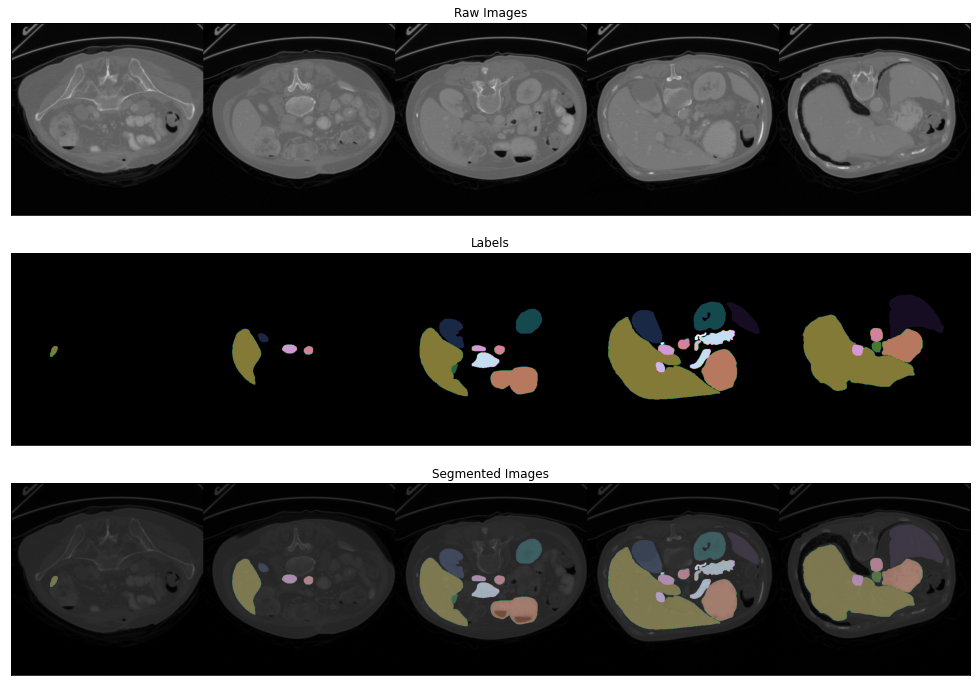

In [3]:
# Define paths towards directories containing the raw images and labels
img_path = "data/raw/train/img"
label_path = "data/raw/train/label"

# Generate lists containing the filenames of every file contained in the img and label directories
img_files = sorted(os.listdir(img_path))
label_files = sorted(os.listdir(label_path))

# Read images and labels
img = sitk.ReadImage(os.path.join(img_path, img_files[0]), sitk.sitkInt16)
label = sitk.ReadImage(os.path.join(label_path, label_files[0]), sitk.sitkInt16)

# Convert images and labels from SimpleITK.Image to numpy.ndarray format
img_arr = sitk.GetArrayFromImage(img)
label_arr = sitk.GetArrayFromImage(label)

# Isolate the indices of every frame that contains labeled data
labeled = []
for i in range(label_arr.shape[0]):
    if label_arr[i,:,:].max() == 0:
        pass
    else:
        labeled.append(i)
print(f'\033[1m\nTotal number of labeled frames:\033[0m {len(labeled)} out of {label_arr.shape[0]}')

# Initialize grid arrays with a column vector of zeros
grid_img = np.zeros((img_arr.shape[1],1))
grid_label = np.zeros((label_arr.shape[1],1))

# Isolate the indices of 5 evenly distanced labeled frames 
for i in range(0,5):  
    frame_idx = labeled[0] + int(img_arr[labeled[0]:].shape[0]/5)*i
    # Stack each new image along the x-axis to generate a grid of 5 stacked images
    grid_img = np.hstack([grid_img, img_arr[frame_idx,:,:]])
    grid_label = np.hstack([grid_label, label_arr[frame_idx,:,:]])

# Display grids
plt.figure(figsize=(18,12))

plt.subplot(311)
plt.imshow(grid_img, cmap='gray')
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title('Raw Images')

plt.subplot(312)
plt.imshow(grid_label, cmap='cubehelix')
plt.title('Labels')
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.subplot(313)
plt.imshow(grid_img, cmap='gray')
plt.imshow(grid_label, alpha=0.6, cmap='cubehelix')
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title('Segmented Images')

plt.show()

This previsualization shows each segmented organ in a different color based on their corresponding labels (1-13).

## Unbalanced data
As in many medical image processing projects, we need to address the potential issue of unbalanced dataset. Indeed, as most of the image represents either background or an unlabeled organ/tissue, most pixels end up being labeled as zeros, which can lead to biases in the resulting model.

To address this, we will first generate a dataframe that stores the total number of labeled frames and total number of frames for each label file in the training set.

In [8]:
# Define paths towards directories containing the raw images and labels
label_path = "data/raw/train/label"

# Generate lists containing the filenames of every file contained in the label directory
label_files = sorted(os.listdir(label_path))

# Initialize empty lists for tracking
labeled_frames = []
total_frames = []

for label_file in label_files:
    
    # Read labels
    label = sitk.ReadImage(os.path.join(label_path, label_file), sitk.sitkInt16)

    # Convert labels from SimpleITK.Image to numpy.ndarray format
    label_arr = sitk.GetArrayFromImage(label)

    # Calculate number of frames that contain labeled data
    labeled = 0
    for i in range(label_arr.shape[0]):
        if label_arr[i,:,:].max() == 0:
            pass
        else:
            labeled += 1
            
    # Appended lists with current number of labeled and total frames for corresponding image
    labeled_frames.append(labeled)
    total_frames.append(label_arr.shape[0])

# Generate DataFrame
labels = pd.DataFrame(np.array([labeled_frames, total_frames]).transpose(), columns=['labeled', 'total'], index=label_files)

In [9]:
# Display first 5 rows of the corresponding DataFrame
labels.head()

labeled  total
label0001.nii.gz       86    147
label0002.nii.gz       75    139
label0003.nii.gz      108    198
label0004.nii.gz       69    140
label0005.nii.gz       94    117

Now, we can look at some descriptive statitics.

In [10]:
print(f"Minimum number of labeled image: {labels['labeled'].min():7.0f}")
print(f"Minimum number of frames per image: {labels['total'].min():4.0f}")

Minimum number of labeled image:      48
Minimum number of frames per image:   85


**OBSERVATIONS**
- To minimize the impact of having unbalanced data, we will train the model using a sub-selection of 48 frames per image, which corresponds to the minimum number of labeled image found in the training set.
- Ideally, we would want each sub-selection to only include labeled images, but since we also need each image to be equally distanced (i.e. same distance between two consecutive frames), **the best approach would be to find the indices of the first and last labeled frames for each image and sub-select a random set of 48 consecutive frames located between these two indices.**

___
# Data Pre-Processing

This section illustrates two pre-processing processes:

- **Data filtering**
- **Data augmentation**

## Data filtering
The script below enables the following pre-processing operations:
1. Use interpolation to normalize spacing between frames
2. Apply a grayscale filter to remove high intensity values
3. Indentify first and last frames containing labeled data and remove frames out of the resulting range
4. Export pre-processed data in Nifti (.nii) format

### Define pre-processing parameters

In [66]:
# Distance between frames
interframe_distance = 3

# Zoom factor along the y- and z-axes
yz_zoom_factor = 0.25

# Grayscale threshold
#   -> Sets any value > grayscale_threshold = grayscale_threshold
#   -> Sets any value < -grayscale_threshold = -grayscale_threshold
grayscale_threshold = 350

### Apply pre-processing operations to training data

In [67]:
# Define paths towards directories containing the raw images and labels
img_path = "data/raw/train/img"
label_path = "data/raw/train/label"

# Define paths towards directories containing the processed images and labels
processed_img_path = "data/processed/train/img"
processed_label_path = "data/processed/train/label"

# Initialize time tracker
start_time = time()

# Generate lists containing the filenames of every file contained in the img and label directories
img_files = sorted(os.listdir(img_path))
label_files = sorted(os.listdir(label_path))
files = np.array([img_files, label_files]).transpose()

for i, (img_file, label_file) in enumerate(files):
    
    # Read images and labels
    img = sitk.ReadImage(os.path.join(img_path, img_file), sitk.sitkInt16)
    label = sitk.ReadImage(os.path.join(label_path, label_file), sitk.sitkInt16)
    
    # Convert images and labels from SimpleITK.Image to numpy.ndarray format
    img_arr = sitk.GetArrayFromImage(img)
    label_arr = sitk.GetArrayFromImage(label)
    
    # Calculate zoom factors and resulting spacing
    zoom_factors = (img.GetSpacing()[-1]/interframe_distance, yz_zoom_factor, yz_zoom_factor)
    spacing = (img.GetSpacing()[0]*int(1/yz_zoom_factor), img.GetSpacing()[1]*int(1/yz_zoom_factor), interframe_distance)
    
    # Use interpolation to downsample the image by defined factor
    img_arr = ndimage.zoom(img_arr, zoom_factors, order=3)
    label_arr = ndimage.zoom(label_arr, zoom_factors, order=0)
    
    # Ensure that the shape of the downsampled images and labels is even
    if img_arr.shape[1]%2 !=0:
        pad_shape = ((0,0), (0, 1), (0, 1))
        img_arr = np.pad(img_arr, pad_shape, 'constant', constant_values=-grayscale_threshold)
        label_arr = np.pad(label_arr, pad_shape, 'constant', constant_values=0)
        
    # Apply a grayscale filter to remove high intensity values
    img_arr[img_arr>grayscale_threshold] = grayscale_threshold
    img_arr[img_arr<-grayscale_threshold] = -grayscale_threshold
    
    # Run test to find all frames containing labeled data (returns True when frame contains at least 1 value different from 0)
    label_test = np.any(label_arr, axis=(1,2))
    
    # Indentify first and last frames containing labeled data 
    first_labeled_frame = np.where(label_test)[0][0]
    last_labeled_frame = np.where(label_test)[0][-1]
    
    # Remove frames out of the resulting range
    img_arr = img_arr[first_labeled_frame:last_labeled_frame]
    label_arr = label_arr[first_labeled_frame:last_labeled_frame]
    
    # Convert images and labels from numpy.ndarray to SimpleITK.Image format
    processed_img = sitk.GetImageFromArray(img_arr)
    processed_label = sitk.GetImageFromArray(label_arr)
    
    # Set original images properties to pre-processed images and labels
    processed_img.SetDirection(img.GetDirection())
    processed_img.SetOrigin(img.GetOrigin())
    processed_img.SetSpacing(spacing)
    processed_label.SetDirection(img.GetDirection())
    processed_label.SetOrigin(img.GetOrigin())
    processed_label.SetSpacing(spacing)
    
    # Export pre-processed images and labels in Nifti (.nii) format
    sitk.WriteImage(processed_img, os.path.join(processed_img_path, img_file[:-3]))
    sitk.WriteImage(processed_label, os.path.join(processed_label_path, label_file[:-3]))
    
    print(f"Images and labels #{img_file[3:-7]} processed and exported")

# Print total computing time
total_time = time() - start_time
print(f'\033[1m\nTotal computing time:\033[0m {total_time//3600:2.0f} hrs '
      f'{(total_time - total_time//3600*3600)//60:2.0f} mins '
      f'{total_time%60:2.0f} secs')

Images and labels #0001 processed and exported
Images and labels #0002 processed and exported
Images and labels #0003 processed and exported
Images and labels #0004 processed and exported
Images and labels #0005 processed and exported
Images and labels #0006 processed and exported
Images and labels #0007 processed and exported
Images and labels #0008 processed and exported
Images and labels #0009 processed and exported
Images and labels #0010 processed and exported
Images and labels #0021 processed and exported
Images and labels #0022 processed and exported
Images and labels #0023 processed and exported
Images and labels #0024 processed and exported
Images and labels #0025 processed and exported
Images and labels #0026 processed and exported
Images and labels #0027 processed and exported
Images and labels #0028 processed and exported
Images and labels #0029 processed and exported
Images and labels #0030 processed and exported
Images and labels #0031 processed and exported
Images and la

## Data augmentation
Data augmentation is a technique that can be used to artificially expand the size and diversity of a dataset by creating variations of the samples that can improve the ability of the model to generalize to new unseen images.

In image processing, common data augmentation strategies include rotating, cropping, flipping, resizing, etc.

In the field of medical images, augmentation transformations should remain minimal as most images are collected using a standardized protocol and therefore are not expected to differ significantly between samples.

### Augmentation strategies
In the script below, we will illustrate the three augmentation strategies implemented in this dataset:
- **Random rotation**

    This operation will allow each sample to be rotated by a random angle comprised between a defined range.  
    
    
- **Random warping**

    This operation will allow each sample to be randomly warped along the x- and y-axes, resulting in an altered image ratio (e.g. slightly elongated image along a random direction, accounting for potential differences in patient morphology).


- **Random cropping**

    This operation will allow each sample to be randomly cropped.
    
**NOTE:** To facilitate visualization, the rotation and warping ranges will be dramatically enlarged in the script below. When defining the final dataset used for training, these ranges will remain minimal as medical images are acquired using a standardized protocol and patient orientation.

### Augmentation parameters

In [3]:
# Distance between frames
interframe_distance = 3

# Zoom factor along the y- and z-axes
yz_zoom_factor = 0.25

# Grayscale threshold
#   -> Sets any value > grayscale_threshold = grayscale_threshold
#   -> Sets any value < -grayscale_threshold = -grayscale_threshold
grayscale_threshold = 350

# Define number of consecutive frames to select out of the images and labels
consecutive_frames = 48

# Define rotation angle range for data augmentation
#   e.g. if set to 5, each transformed image is randomly rotated by an angle comprised between -5 and +5 degrees
rotation_range = 90

# Define warping range for data augmentation
#   e.g. if set to 0.6, each transformed image is randomly resized along the x- and y-axes by a factor
#   comprised between 60% and 100% of the original image shape (with different factors for each direction).
#   The resize image is then re-resize to the original image shape by filling the cropped pixels with black pixels
#   (giving the impression of warping)
warping_range = 0.4

# Define cropping ratio range for data augmentation
#   e.g. if crop_lower_range = 0.5 and crop_upper_range = 0.8, each transformed image is randomly cropped
#   along the x- and y-axes by a factor comprised between 50% and 80% of the original image dimensions
crop_lower_range = 0.5
crop_upper_range = 0.8
cropping_ratio = np.random.uniform(crop_lower_range, crop_upper_range)

### Augmentation pre-visualization

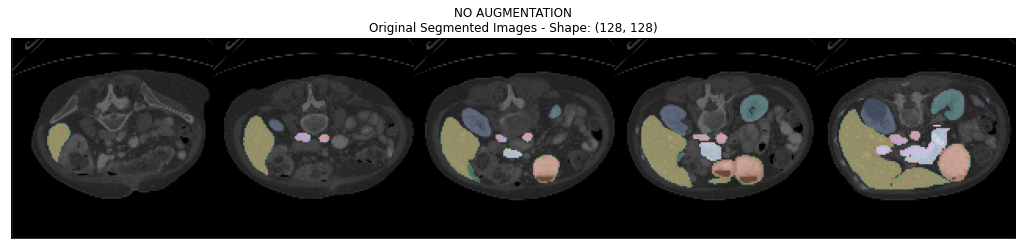

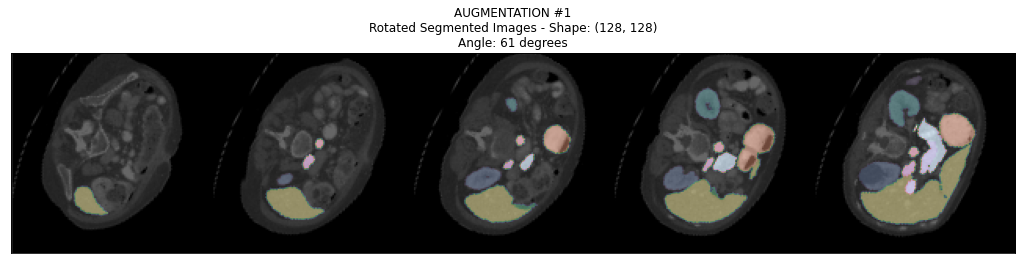

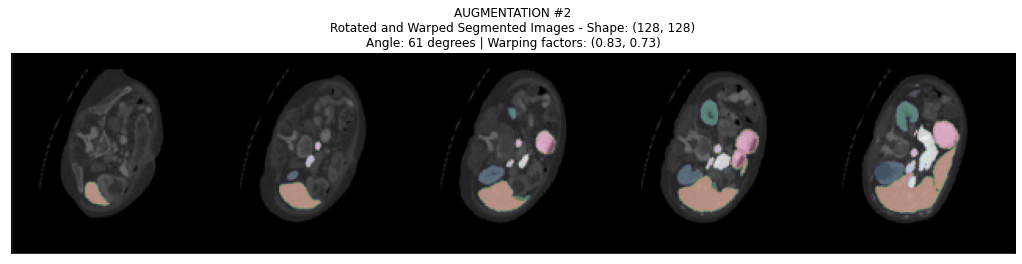

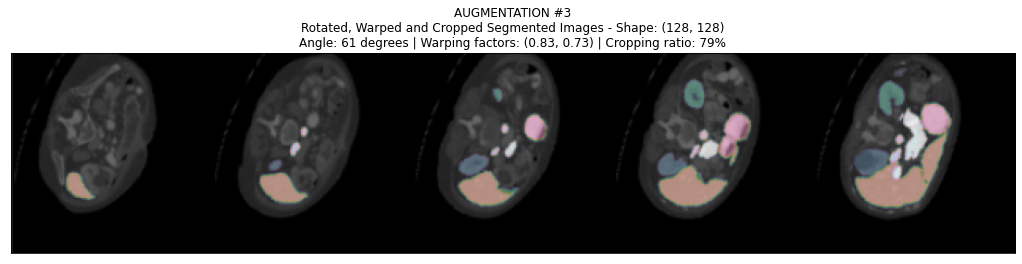

In [4]:
# Define path towards the directory containing the raw images and labels
path = "data/processed/train"

# Generate paths towards images and labels directories
img_path = os.path.join(path, 'img')
label_path = os.path.join(path, 'label')

# Generate lists of filenames for all images and labels contained within corresponding directories (with full path)
img_files = list(map(lambda img_file: os.path.join(img_path, img_file), sorted(os.listdir(img_path))))
label_files = list(map(lambda label_file: os.path.join(label_path, label_file), sorted(os.listdir(label_path))))

# Get full paths to first images and corresponding labels
img_path = img_files[0]
label_path = label_files[0]

# Read images and labels
img = sitk.ReadImage(img_path, sitk.sitkInt16)
label = sitk.ReadImage(label_path, sitk.sitkInt16)

# Convert images and labels from SimpleITK.Image to numpy.ndarray format
img_arr = sitk.GetArrayFromImage(img)
label_arr = sitk.GetArrayFromImage(label)

# Select N random consecutive frames from the image and label
random_start_frame = np.random.randint(0, img_arr.shape[0]-consecutive_frames)
img_arr = img_arr[random_start_frame:random_start_frame+consecutive_frames,:,:]
label_arr = label_arr[random_start_frame:random_start_frame+consecutive_frames,:,:]

# Display original images (prior to augmentation)
#   Initialize grid arrays with a column vector of zeros
grid_img = np.zeros((img_arr.shape[1],1))
grid_label = np.zeros((label_arr.shape[1],1))
#   Isolate 5 evenly distanced labeled frames 
for i in [9, 18, 27, 36, 45]:  
    #   Stack each new image along the x-axis to generate a grid of 5 stacked images
    grid_img = np.hstack([grid_img, img_arr[i,:,:]])
    grid_label = np.hstack([grid_label, label_arr[i,:,:]])
# Generate plot
plt.figure(figsize=(18,6))
plt.imshow(grid_img, cmap='gray')
plt.imshow(grid_label, alpha=0.6, cmap='cubehelix')
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title(f'NO AUGMENTATION\nOriginal Segmented Images - Shape: {(img_arr.shape[1], img_arr.shape[2])}')

# Data augmentation 1: apply random rotation to image (based on defined rotation range)
angle = np.random.uniform(-rotation_range,rotation_range)
img_arr = ndimage.rotate(img_arr, angle, axes=(1,2), reshape=False, order=1, cval=-grayscale_threshold)
label_arr = ndimage.rotate(label_arr, angle, axes=(1,2), reshape=False, order=1, cval=0)
# Display rotated images
#   Initialize grid arrays with a column vector of zeros
grid_img = np.zeros((img_arr.shape[1],1))
grid_label = np.zeros((label_arr.shape[1],1))
#   Isolate 5 evenly distanced labeled frames 
for i in [9, 18, 27, 36, 45]:  
    #   Stack each new image along the x-axis to generate a grid of 5 stacked images
    grid_img = np.hstack([grid_img, img_arr[i,:,:]])
    grid_label = np.hstack([grid_label, label_arr[i,:,:]])
# Generate plot
plt.figure(figsize=(18,6))
plt.imshow(grid_img, cmap='gray')
plt.imshow(grid_label, alpha=0.6, cmap='cubehelix')
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title(f'AUGMENTATION #1\nRotated Segmented Images - Shape: {(img_arr.shape[1], img_arr.shape[2])}\n'
          f'Angle: {angle:0.0f} degrees')
plt.show()

# Data augmentation 2: apply random warping to image (based on defined warping range)
#   Save original images and labels shape
x_shape, y_shape = img_arr.shape[1], img_arr.shape[2]
#   Generate random warping factors along x- and y-axes
warping_x = np.random.uniform(warping_range,1)
warping_y = np.random.uniform(warping_range,1)
#   Warp images and labels
img_arr = ndimage.zoom(img_arr, (1,warping_x,warping_y), order=1, cval=-grayscale_threshold)
label_arr = ndimage.zoom(label_arr, (1,warping_x,warping_y), order=1, cval=0)
#   Calculate number of rows and columns to add shape
n_rows = x_shape - img_arr.shape[1]
n_cols = y_shape - img_arr.shape[2]
#   Calculate padding shape
if n_rows%2 == 0 and n_cols%2 == 0:
    pad_shape = ((0,0), (int(n_rows/2), int(n_rows/2)), (int(n_cols/2), int(n_cols/2)))
elif n_rows%2 != 0 and n_cols%2 == 0:
    pad_shape = ((0,0), (math.ceil(n_rows/2), math.floor(n_rows/2)), (int(n_cols/2), int(n_cols/2)))
elif n_rows%2 == 0 and n_cols%2 != 0:
    pad_shape = ((0,0), (int(n_rows/2), int(n_rows/2)), (math.ceil(n_cols/2), math.floor(n_cols/2)))
elif n_rows%2 != 0 and n_cols%2 != 0:
    pad_shape = ((0,0), (math.ceil(n_rows/2), math.floor(n_rows/2)), (math.ceil(n_cols/2), math.floor(n_cols/2)))
#   Pad images and labels to match original shape
img_arr = np.pad(img_arr, pad_shape, 'constant', constant_values=-grayscale_threshold)
label_arr = np.pad(label_arr, pad_shape, 'constant', constant_values=0)
# Display rotated and wraped images
#   Initialize grid arrays with a column vector of zeros
grid_img = np.zeros((img_arr.shape[1],1))
grid_label = np.zeros((label_arr.shape[1],1))
#   Isolate 5 evenly distanced labeled frames 
for i in [9, 18, 27, 36, 45]:  
    #   Stack each new image along the x-axis to generate a grid of 5 stacked images
    grid_img = np.hstack([grid_img, img_arr[i,:,:]])
    grid_label = np.hstack([grid_label, label_arr[i,:,:]])
# Generate plot
plt.figure(figsize=(18,6))
plt.imshow(grid_img, cmap='gray')
plt.imshow(grid_label, alpha=0.6, cmap='cubehelix')
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title(f'AUGMENTATION #2\nRotated and Warped Segmented Images - Shape: {(img_arr.shape[1], img_arr.shape[2])}\n'
          f'Angle: {angle:0.0f} degrees | Warping factors: ({warping_x:0.2f}, {warping_y:0.2f})')
plt.show()

# Data augmentation 3: apply random cropping to image
#   Define cropped image length (NOTE: the value of 256 is because the original image had a length of 512 pixels,
#   which was multiplied by a factor of 0.5 when filtering the data,
#   resulting in a processed image of dimensions 256x256 pixels)
cropped_length = int(256 * cropping_ratio)
#   Define random coordinates for bottom left corner of the cropping area
x1 = int(np.random.uniform(0, 255 - cropped_length))
y1 = int(np.random.uniform(0, 255 - cropped_length))
#   Define random coordinates for top right corner of the cropping area
x2 = x1 + cropped_length
y2 = y1 + cropped_length
#   Crop images and labels
img_arr = img_arr[:, x1:x2+1, y1:y2+1]
label_arr = label_arr[:, x1:x2+1, y1:y2+1]
#   Upsample cropped images and labels to match with original image size (i.e. 256x256 pixels)
with torch.no_grad():
    img_arr = torch.FloatTensor(img_arr).unsqueeze(dim=0).unsqueeze(dim=0)
    img_arr = F.upsample(img_arr, (consecutive_frames, 128, 128), mode='trilinear').squeeze().detach().numpy()
    label_arr = torch.FloatTensor(label_arr).unsqueeze(dim=0).unsqueeze(dim=0)
    label_arr = F.upsample(label_arr, (consecutive_frames, 128, 128), mode='trilinear').squeeze().detach().numpy()
# Display rotated, wraped and cropped images
#   Initialize grid arrays with a column vector of zeros
grid_img = np.zeros((img_arr.shape[1],1))
grid_label = np.zeros((label_arr.shape[1],1))
#   Isolate 5 evenly distanced labeled frames 
for i in [9, 18, 27, 36, 45]:  
    #   Stack each new image along the x-axis to generate a grid of 5 stacked images
    grid_img = np.hstack([grid_img, img_arr[i,:,:]])
    grid_label = np.hstack([grid_label, label_arr[i,:,:]])
# Generate plot
plt.figure(figsize=(18,6))
plt.imshow(grid_img, cmap='gray')
plt.imshow(grid_label, alpha=0.6, cmap='cubehelix')
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title((f'AUGMENTATION #3\nRotated, Warped and Cropped Segmented Images - Shape: {(img_arr.shape[1], img_arr.shape[2])}\n'
           f'Angle: {angle:0.0f} degrees | Warping factors: ({warping_x:0.2f}, {warping_y:0.2f}) | Cropping ratio: {cropping_ratio*100:2.0f}%'))
plt.show()

___
# Dataset definition

To facilitate the import and formatting of the data and enable the use of PyTorch DataLoader, a new class called _ProcessedDataset_ is created.

This _ProcessedDataset_ class will also enable the following operations:
1. Random selection of N consecutive frames
2. Random application of augmentation transformations (rotation, warping and cropping)

**NOTE:** The different dataset parameters can eventually be changed using the cell below.

## Dataset parameters

In [7]:
# Distance between frames
interframe_distance = 3

# Zoom factor along the y- and z-axes
yz_zoom_factor = 0.25

# Grayscale threshold
#   -> Sets any value > grayscale_threshold = grayscale_threshold
#   -> Sets any value < -grayscale_threshold = -grayscale_threshold
grayscale_threshold = 350

# Define number of consecutive frames to select out of the images and labels
consecutive_frames = 48

# Define data augmentation probability
#   e.g. if set to 0.5, each image has a 50% chance to be transformed
augmentation_probability = 0.5

# Define rotation angle range for data augmentation
#   e.g. if set to 5, each transformed image is randomly rotated by an angle comprised between -5 and +5 degrees
rotation_range = 5

# Define warping range for data augmentation
#   e.g. if set to 0.6, each transformed image is randomly resized along the x- and y-axes by a factor
#   comprised between 60% and 100% of the original image shape (with different factors for each direction).
#   The resize image is then re-resize to the original image shape by filling the cropped pixels with black pixels
#   (giving the impression of warping)
warping_range = 0.8

# Define cropping ratio range for data augmentation
#   e.g. if crop_lower_range = 0.5 and crop_upper_range = 0.8, each transformed image is randomly cropped
#   along the x- and y-axes by a factor comprised between 50% and 80% of the original image dimensions
crop_lower_range = 0.5
crop_upper_range = 0.8
cropping_ratio = np.random.uniform(crop_lower_range, crop_upper_range)

## Dataset class definition (including random data augmentation)

In [8]:
class ProcessedDataset(Dataset):
    
    def __init__(self, path, rotation=True, warping=True, cropping=True):
        '''
        ProcessedDataset(path, rotation=True, warping=True, cropping=True)
            Class enabling the definition of a dataset of 3D images with embedded augmentation strategies 
        Parameters:
            path: full path to data
                the corresponding 'data' folder should contain the following subfolders:
                    - 'img': containing the raw (or pre-processed) 3D images
                    - 'label': containing the corresponding labels (same shape as images files)
                (type: string)
            rotation: specifies whether rotation augmentation should be applied
                (type: boolean - True to apply rotation augmentation, False NOT to apply rotation augmentation) [default = True]
            warping: specifies whether warping augmentation should be applied
                (type: boolean - True to apply warping augmentation, False NOT to apply warping augmentation) [default = True]
            cropping: specifies whether cropping augmentation should be applied
                (type: boolean - True to apply cropping augmentation, False NOT to apply cropping augmentation) [default = True]
        '''
        
        # Generate paths towards images and labels directories
        self.img_path = os.path.join(path, 'img')
        self.label_path = os.path.join(path, 'label')
        
        # Generate lists of filenames for all images and labels contained within corresponding directories (with full path)
        self.img_files = list(map(lambda img_file: os.path.join(self.img_path, img_file), sorted(os.listdir(self.img_path))))
        self.label_files = list(map(lambda label_file: os.path.join(self.label_path, label_file), sorted(os.listdir(self.label_path))))

        # Specify which augmentation strategy to apply
        self.rotation = rotation
        self.warping = warping
        self.cropping = cropping
        
    def __getitem__(self, index):
        
        # Get full paths to selected images and labels
        img_path = self.img_files[index]
        label_path = self.label_files[index]
        
        # Read images and labels
        img = sitk.ReadImage(img_path, sitk.sitkInt16)
        label = sitk.ReadImage(label_path, sitk.sitkInt16)

        # Convert images and labels from SimpleITK.Image to numpy.ndarray format
        img_arr = sitk.GetArrayFromImage(img)
        label_arr = sitk.GetArrayFromImage(label)
        
        # Select N random consecutive frames from the image and label
        random_start_frame = np.random.randint(0, img_arr.shape[0]-consecutive_frames)
        img_arr = img_arr[random_start_frame:random_start_frame+consecutive_frames,:,:]
        label_arr = label_arr[random_start_frame:random_start_frame+consecutive_frames,:,:]
        
        # Data augmentation 1: apply random rotation to image (based on defined probability and range)
        if self.rotation:
            if np.random.uniform(0,1) >= augmentation_probability:
                angle = np.random.uniform(-rotation_range,rotation_range)
                img_arr = ndimage.rotate(img_arr, angle, axes=(1,2), reshape=False, order=1, cval=-grayscale_threshold)
                label_arr = ndimage.rotate(label_arr, angle, axes=(1,2), reshape=False, order=1, cval=0)
        
        # Data augmentation 2: apply random warping to image (based on defined probability and range)
        if self.warping:
            if np.random.uniform(0,1) >= augmentation_probability:     
                #   Save original images and labels shape
                x_shape, y_shape = img_arr.shape[1], img_arr.shape[2]
                #   Generate random warping factors along x- and y-axes
                warping_x = np.random.uniform(warping_range,1)
                warping_y = np.random.uniform(warping_range,1)
                #   Warp images and labels
                img_arr = ndimage.zoom(img_arr, (1,warping_x,warping_y), order=1, cval=-grayscale_threshold)
                label_arr = ndimage.zoom(label_arr, (1,warping_x,warping_y), order=1, cval=0)
                #   Calculate number of rows and columns to add shape
                n_rows = x_shape - img_arr.shape[1]
                n_cols = y_shape - img_arr.shape[2]
                #   Calculate padding shape
                if n_rows%2 == 0 and n_cols%2 == 0:
                    pad_shape = ((0,0), (int(n_rows/2), int(n_rows/2)), (int(n_cols/2), int(n_cols/2)))
                elif n_rows%2 != 0 and n_cols%2 == 0:
                    pad_shape = ((0,0), (math.ceil(n_rows/2), math.floor(n_rows/2)), (int(n_cols/2), int(n_cols/2)))
                elif n_rows%2 == 0 and n_cols%2 != 0:
                    pad_shape = ((0,0), (int(n_rows/2), int(n_rows/2)), (math.ceil(n_cols/2), math.floor(n_cols/2)))
                elif n_rows%2 != 0 and n_cols%2 != 0:
                    pad_shape = ((0,0), (math.ceil(n_rows/2), math.floor(n_rows/2)), (math.ceil(n_cols/2), math.floor(n_cols/2)))
                #   Pad images and labels to match original shape
                img_arr = np.pad(img_arr, pad_shape, 'constant', constant_values=-grayscale_threshold)
                label_arr = np.pad(label_arr, pad_shape, 'constant', constant_values=0)

        # Data augmentation 3: apply random cropping to image (based on defined probability and range)
        if self.cropping:
            if np.random.uniform(0,1) >= augmentation_probability:
                #   Save original images and labels shape
                x_shape, y_shape = img_arr.shape[1], img_arr.shape[2]
                #   Define cropped image length
                cropped_length = int(x_shape * cropping_ratio)
                #   Define random coordinates for bottom left corner of the cropping area
                x1 = int(np.random.uniform(0, x_shape-1 - cropped_length))
                y1 = int(np.random.uniform(0, y_shape-1 - cropped_length))
                #   Define random coordinates for top right corner of the cropping area
                x2 = x1 + cropped_length
                y2 = y1 + cropped_length
                #   Crop images and labels
                img_arr = img_arr[:, x1:x2+1, y1:y2+1]
                label_arr = label_arr[:, x1:x2+1, y1:y2+1]
                #   Upsample cropped images and labels to match with original image size
                with torch.no_grad():
                    img_arr = torch.FloatTensor(img_arr).unsqueeze(dim=0).unsqueeze(dim=0)
                    img_arr = F.upsample(img_arr, (consecutive_frames, x_shape, y_shape), mode='trilinear').squeeze().detach().numpy()
                    label_arr = torch.FloatTensor(label_arr).unsqueeze(dim=0).unsqueeze(dim=0)
                    label_arr = F.upsample(label_arr, (consecutive_frames, x_shape, y_shape), mode='trilinear').squeeze().detach().numpy()

        # Convert images and labels from numpy.ndarray to torch.FloatTensor format
        img_tensor = torch.FloatTensor(img_arr).unsqueeze(0)
        label_tensor = torch.FloatTensor(label_arr)
        
        return img_tensor, label_tensor
        
    def __len__(self):
        
        return len(self.img_files)

## Generate dataset and check the size and type of each sample

In [72]:
# Define path towards directory containing the pre-processed images and labels
path = "data/processed/train"

# Generate dataset
train = ProcessedDataset(path)

# Define DataLoader parameters
batch_size = 1
num_workers = 0
pin_memory = False

# Load dataset
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# Print shape of each sample in the training set
for i, (img, label) in enumerate(train_loader): 
    print(f'\033[1mShape of Sample #{i+1}:\033[0m\t{img.shape}')

Shape of Sample #1:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #2:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #3:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #4:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #5:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #6:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #7:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #8:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #9:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #10:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #11:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #12:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #13:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #14:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #15:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #16:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #17:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #18:	torch.Size([1, 1, 48, 128, 128])
Shape of Sample #19:	torch.Size([1, 1

## Generate dataset and display 5 evenly distanced labeled frames from the first sample

Shape of Sample #1:	torch.Size([1, 1, 48, 128, 128])


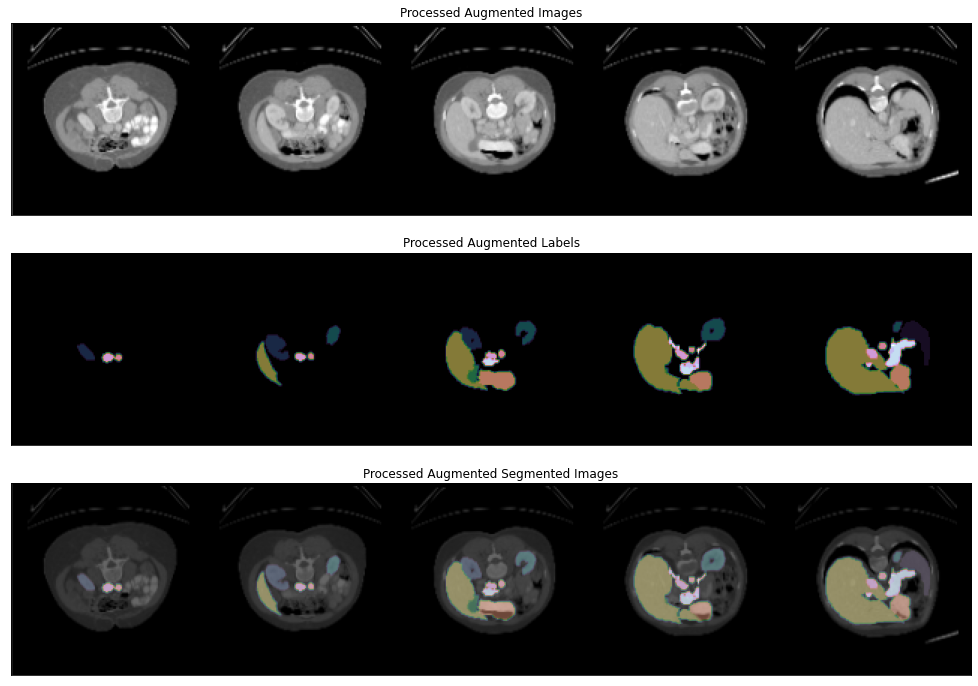

In [73]:
# Define paths towards directories containing the pre-processed images and labels
path = "data/processed/train"

# Generate dataset
train = ProcessedDataset(path)

# Define DataLoader parameters
batch_size = 1
num_workers = 0
pin_memory = False

# Load dataset
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# Grab the first sample
for i, (img, label) in enumerate(train_loader):
    break

# Print first sample shape
print(f'\033[1mShape of Sample #{i+1}:\033[0m\t{img.shape}')

# Resize to 3D array and convert to numpy.ndarray 
img_arr = img.resize(img.shape[2], img.shape[3], img.shape[4]).numpy()
label_arr = label.resize(label.shape[1], label.shape[2], label.shape[3]).numpy()

#   Initialize grid arrays with a column vector of zeros
grid_img = np.zeros((img_arr.shape[1],1))
grid_label = np.zeros((label_arr.shape[1],1))

# Isolate the indices of 5 evenly distanced labeled frames and 
for i in [9, 18, 27, 36, 45]:
    # Stack each new image along the x-axis to generate a grid of 5 stacked images
    grid_img = np.hstack([grid_img, img_arr[i,:,:]])
    grid_label = np.hstack([grid_label, label_arr[i,:,:]])

# Display grids
plt.figure(figsize=(18,12))

plt.subplot(311)
plt.imshow(grid_img, cmap='gray')
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title('Processed Augmented Images')

plt.subplot(312)
plt.imshow(grid_label, cmap='cubehelix')
plt.title('Processed Augmented Labels')
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.subplot(313)
plt.imshow(grid_img, cmap='gray')
plt.imshow(grid_label, alpha=0.6, cmap='cubehelix')
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title('Processed Augmented Segmented Images')

plt.show()

## Augmentation verification
The concept of augmentation is that, for every epoch, the samples generate by the DataLoader will be slightly altered by the different augmentation strategies defined in the _ProcessedDataset_ class.

In other words, every time we enumerate through the _ProcessedDataset_ using PyTorch's DataLoader, the resulting samples will be loaded with a different set of random augmentation transformations. This process allows the network to better generalize, as a new set of images is used for every epoch instead of reusing the exact same set.

To better illustrate this, the cell below is only iterating through the DataLoader without generating a new _ProcessedDataset_ and should result in a different batch (i.e. shuffle images with different augmentation parameters) everytime the cell is run.

Shape of Sample #1:	torch.Size([1, 1, 48, 128, 128])


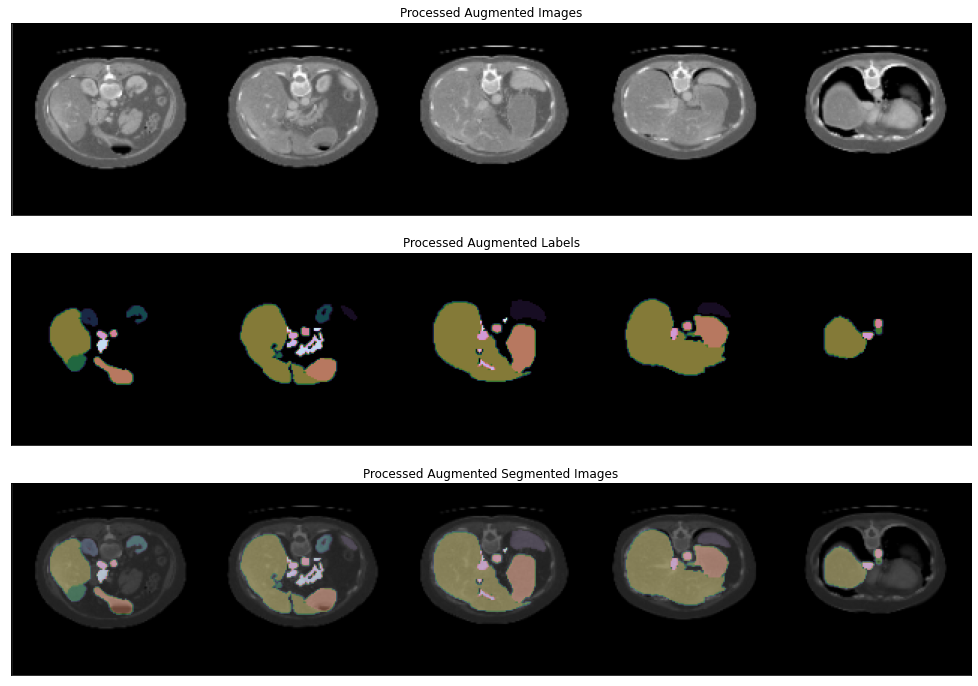

In [75]:
# Grab the first sample
for i, (img, label) in enumerate(train_loader):
    break

# Print first sample shape
print(f'\033[1mShape of Sample #{i+1}:\033[0m\t{img.shape}')

# Resize to 3D array and convert to numpy.ndarray 
img_arr = img.resize(img.shape[2], img.shape[3], img.shape[4]).numpy()
label_arr = label.resize(label.shape[1], label.shape[2], label.shape[3]).numpy()

#   Initialize grid arrays with a column vector of zeros
grid_img = np.zeros((img_arr.shape[1],1))
grid_label = np.zeros((label_arr.shape[1],1))

# Isolate the indices of 5 evenly distanced labeled frames and 
for i in [9, 18, 27, 36, 45]:
    # Stack each new image along the x-axis to generate a grid of 5 stacked images
    grid_img = np.hstack([grid_img, img_arr[i,:,:]])
    grid_label = np.hstack([grid_label, label_arr[i,:,:]])

# Display grids
plt.figure(figsize=(18,12))

plt.subplot(311)
plt.imshow(grid_img, cmap='gray')
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title('Processed Augmented Images')

plt.subplot(312)
plt.imshow(grid_label, cmap='cubehelix')
plt.title('Processed Augmented Labels')
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

plt.subplot(313)
plt.imshow(grid_img, cmap='gray')
plt.imshow(grid_label, alpha=0.6, cmap='cubehelix')
ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.title('Processed Augmented Segmented Images')

plt.show()

___
# Model Implementation

This section will focus on:
- **Model architecture**
- **3D fully convolutional network definition**
- **Multi-scale pyramid implementation**
- **Loss function definition**
- **Optimizer definition**

## Model architecture
The selected architecture was based off the work of Roth et al. (2018) [1], which uses a multi-scale pyramid 3D fully convolutional network (FCN).

In this architecture, the pre-processed samples are first passed through the 3D FCN (stage 1), which predictions are upsampled, cropped and concatenated with a zoomed-in version of the samples before being passed through the 3D FCN one more time (stage 2) and generate the final output (see Figure below).

This architecture can help improve the performance of the network by better integrating scale differences, which is necessary when dealing with multi-organ image segmentation (i.e. each organ being at a different scale, such as the liver, which is much larger compared toa kidney for instance).

![png](img/Multi-scale_pyramid_3D_FCN_(Roth_et_al.).png)

[1] Roth HR, Shen C, Oda H, Sugino T, Oda M, Hayashi Y, Misawa K, Mori K. A multi-scale pyramid of 3D fully convolutional
networks for abdominal multi-organ segmentation. arXiv:1806.02237v1, 2018 (https://arxiv.org/abs/1806.02237)

## 3D fully convolutional network definition
First, we need to define the 3D FCN architecture that will be used in each stage of this multi-scale pyramid approach. The architecture defined below is an multiclass adaptation of the V-Net FCN developed by Milletari et al. (2016) [2].

### V-Net architecture
The V-Net architecture consists of 2 paths:
- **Compression path (left)**: divided into stages comprising up to three convolutional layers that operate at a different resolution. In contrast to a U-Net architecture, a residual function is learnt at each stage to ensure convergence and each pooling layer is replaced by convolutional ones, which helps reduce memory requirements during training.
- **Decompression path (right)**: also divided into stages comprising up to three convolutional layers, the decompression path allows the extraction of features from lower resolution feature maps and uses deconvolution to progressively increase the resolution until reaching the original input size. Residual functions are also learnt at each stage.

![png](img/V-Net_architecture.png)

For more details on V-Net, please read the original article by Milletari et al. (2016) [2] or check out this review posted on Towards Data Science.

https://towardsdatascience.com/review-v-net-volumetric-convolution-biomedical-image-segmentation-aa15dbaea974

[2] Milletari F, Navab N, Ahmadi SA. V-Net: Fully Convolutional Neural Networks for
Volumetric Medical Image Segmentation. arXiv:1606.04797v1, 2016 (https://arxiv.org/abs/1606.04797)

In [3]:
class MultiLabelVNet(nn.Module):
    
    def __init__(self, training, input_shape, num_channels, num_labels, stage):
        '''
        MultiLabelVNet(training, input_shape, num_channels, num_labels, stage)
            Multiclass adaptation of the V-Net Fully Convolutional Network (FCN) developed by Milletari et al. (2016) [1]
            [1] Milletari F, Navab N, Ahmadi SA. V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation.
            arXiv:1606.04797v1, 2016 (https://arxiv.org/abs/1606.04797)
        Parameters:
            training: specifies whether the network is currently being used for training or testing
                (type: boolean - True for training, False for testing)
            input_shape: specifies shape of input image (e.g. input_shape=128 for input images of size 128x128)
                (type: integer)
            num_channels: specifies number of input channels (type: integer)
            num_labels: specifies number of labels (type: integer)
            stage: specifies current stage
                (type: string - 'stage 1' for 1st pass through 3D FCN, 'stage 2' for 2nd pass)
        '''
        
        super().__init__()
        
        self.training = training        
        self.stage = stage
        
        # ENCODER        
        self.encoder1 = nn.Sequential(nn.Conv3d(num_channels, int(input_shape/16), 3, 1, padding=1),
                                      nn.PReLU(int(input_shape/16)))   
        self.encoder2 = nn.Sequential(nn.Conv3d(int(input_shape/8), int(input_shape/8), 3, 1, padding=1),
                                      nn.PReLU(int(input_shape/8)),
                                      nn.Conv3d(int(input_shape/8), int(input_shape/8), 3, 1, padding=1),
                                      nn.PReLU(int(input_shape/8)))        
        self.encoder3 = nn.Sequential(nn.Conv3d(int(input_shape/4), int(input_shape/4), 3, 1, padding=1),
                                      nn.PReLU(int(input_shape/4)),
                                      nn.Conv3d(int(input_shape/4), int(input_shape/4), 3, 1, padding=2, dilation=2),
                                      nn.PReLU(int(input_shape/4)),
                                      nn.Conv3d(int(input_shape/4), int(input_shape/4), 3, 1, padding=4, dilation=4),
                                      nn.PReLU(int(input_shape/4)))        
        self.encoder4 = nn.Sequential(nn.Conv3d(int(input_shape/2), int(input_shape/2), 3, 1, padding=3, dilation=3),
                                      nn.PReLU(int(input_shape/2)),
                                      nn.Conv3d(int(input_shape/2), int(input_shape/2), 3, 1, padding=4, dilation=4),
                                      nn.PReLU(int(input_shape/2)),
                                      nn.Conv3d(int(input_shape/2), int(input_shape/2), 3, 1, padding=5, dilation=5),
                                      nn.PReLU(int(input_shape/2)))
        
        # DECODER        
        self.decoder1 = nn.Sequential(nn.Conv3d(int(input_shape/2), input_shape, 3, 1, padding=1),
                                      nn.PReLU(input_shape),
                                      nn.Conv3d(input_shape, input_shape, 3, 1, padding=1),
                                      nn.PReLU(input_shape),
                                      nn.Conv3d(input_shape, input_shape, 3, 1, padding=1),
                                      nn.PReLU(input_shape))        
        self.decoder2 = nn.Sequential(nn.Conv3d(int(input_shape/2)+int(input_shape/4), int(input_shape/2), 3, 1, padding=1),
                                      nn.PReLU(int(input_shape/2)),
                                      nn.Conv3d(int(input_shape/2), int(input_shape/2), 3, 1, padding=1),
                                      nn.PReLU(int(input_shape/2)),
                                      nn.Conv3d(int(input_shape/2), int(input_shape/2), 3, 1, padding=1),
                                      nn.PReLU(int(input_shape/2)))        
        self.decoder3 = nn.Sequential(nn.Conv3d(int(input_shape/4)+int(input_shape/8), int(input_shape/4), 3, 1, padding=1),
                                      nn.PReLU(int(input_shape/4)),
                                      nn.Conv3d(int(input_shape/4), int(input_shape/4), 3, 1, padding=1),
                                      nn.PReLU(int(input_shape/4)))        
        self.decoder4 = nn.Sequential(nn.Conv3d(int(input_shape/8)+int(input_shape/16), int(input_shape/8), 3, 1, padding=1),
                                      nn.PReLU(int(input_shape/8)))
        
        # DOWN CONVOLUTIONS     
        self.down_conv1 = nn.Sequential(nn.Conv3d(int(input_shape/16), int(input_shape/8), 2, 2),
                                        nn.PReLU(int(input_shape/8)))        
        self.down_conv2 = nn.Sequential(nn.Conv3d(int(input_shape/8), int(input_shape/4), 2, 2),
                                        nn.PReLU(int(input_shape/4)))        
        self.down_conv3 = nn.Sequential(nn.Conv3d(int(input_shape/4), int(input_shape/2), 2, 2),
                                        nn.PReLU(int(input_shape/2)))       
        self.down_conv4 = nn.Sequential(nn.Conv3d(int(input_shape/2), input_shape, 3, 1, padding=1),
                                        nn.PReLU(input_shape))
        
        # UP CONVOLUTIONS     
        self.up_conv1 = nn.Sequential(nn.ConvTranspose3d(input_shape, int(input_shape/2), 2, 2),
                                      nn.PReLU(int(input_shape/2)))        
        self.up_conv2 = nn.Sequential(nn.ConvTranspose3d(int(input_shape/2), int(input_shape/4), 2, 2),
                                      nn.PReLU(int(input_shape/4)))        
        self.up_conv3 = nn.Sequential(nn.ConvTranspose3d(int(input_shape/4), int(input_shape/8), 2, 2),
                                      nn.PReLU(int(input_shape/8)))
        
        # OUTPUT        
        self.map = nn.Sequential(nn.Conv3d(int(input_shape/8), num_labels+1, 1), nn.Softmax(dim=1))
        
    def forward(self, inputs):
        
        # ENCODER + DOWN CONVOLUTIONS
        if self.stage == 'stage1':
            enc_layer1 = self.encoder1(inputs) + inputs
        elif self.stage == 'stage2':
            enc_layer1 = self.encoder1(inputs)            
        down1 = self.down_conv1(enc_layer1)
        
        enc_layer2 = self.encoder2(down1) + down1
        enc_layer2 = F.dropout(enc_layer2, dropout_rate, self.training)        
        down2 = self.down_conv2(enc_layer2)
        
        enc_layer3 = self.encoder3(down2) + down2
        enc_layer3 = F.dropout(enc_layer3, dropout_rate, self.training)        
        down3 = self.down_conv3(enc_layer3)
        
        enc_layer4 = self.encoder4(down3) + down3
        enc_layer4 = F.dropout(enc_layer4, dropout_rate, self.training)        
        down4 = self.down_conv4(enc_layer4)
        
        # DECODER + UP CONVOLUTIONS
        dec_layer1 = self.decoder1(enc_layer4) + down4
        dec_layer1 = F.dropout(dec_layer1, dropout_rate, self.training)        
        up1 = self.up_conv1(dec_layer1)
        
        dec_layer2 = self.decoder2(torch.cat([up1, enc_layer3], dim=1)) + up1
        dec_layer2 = F.dropout(dec_layer2, dropout_rate, self.training)        
        up2 = self.up_conv2(dec_layer2)
        
        dec_layer3 = self.decoder3(torch.cat([up2, enc_layer2], dim=1)) + up2
        dec_layer3 = F.dropout(dec_layer3, dropout_rate, self.training)        
        up3 = self.up_conv3(dec_layer3)
        
        dec_layer4 = self.decoder4(torch.cat([up3, enc_layer1], dim=1)) + up3
        
        # OUTPUT
        output = self.map(dec_layer4)
        
        return output

## Multi-scale pyramid implementation
Now that the 3D FCN architecture has been defined, we need to create a second class that will implement this architecture as a multi-scale pyramid model.

In [4]:
class MultiScalePyramid(nn.Module):
    
    def __init__(self, training):
        '''
        MultiScalePyramid(training)
            Multi-scale Pyramid Fully Convolutional Network (FCN) implementation based off the work of Roth et al. (2018) [1]
            Calls the MultiLabelVNet FCN architecture (i.e. Multiclass adaptation of the V-Net Fully Convolutional Network (FCN) developed by Milletari et al. (2016) [2])
            [1] Roth HR, Shen C, Oda H, Sugino T, Oda M, Hayashi Y, Misawa K, Mori K. A multi-scale pyramid of 3D fully convolutional networks for abdominal multi-organ segmentation. arXiv:1806.02237v1, 2018 (https://arxiv.org/abs/1806.02237)
            [2] Milletari F, Navab N, Ahmadi SA. V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation. arXiv:1606.04797v1, 2016 (https://arxiv.org/abs/1606.04797))
        Parameters:
            training: specifies whether the network is currently being used for training or testing
                (type: boolean - True for training, False for testing)
        '''

        super().__init__()
        
        self.training = training
        
        self.stage1 = MultiLabelVNet(training=training, input_shape=input_shape,
                                     num_channels=1, num_labels=num_labels, stage='stage1')
        self.stage2 = MultiLabelVNet(training=training, input_shape=input_shape,
                                     num_channels=num_labels+2, num_labels=num_labels, stage='stage2')
        
    def forward(self, inputs):
        
        # STAGE 1
        #   Downsample original images by ds1 = 2S (i.e. decrease resolution by a factor of 2)
        stage1_input = F.upsample(inputs, (48, int(input_shape/2), int(input_shape/2)), mode='trilinear')        
        #   Generate stage 1 output by passing downsampled input through the 3D FCN
        stage1_output = self.stage1(stage1_input)        
        #   Upsample output back to original size
        stage1_output = F.upsample(stage1_output, (48, input_shape, input_shape), mode='trilinear')
        
        # STAGE 2
        #   Concatenate stage 1 output with original image
        stage2_input = torch.cat((stage1_output, inputs), dim=1)
        #   Generate stage 2 output by passing stage 2 input through the 3D FCN
        stage2_output = self.stage2(stage2_input)
        
        # Return results based on training status
        if self.training == True:
            return stage1_output, stage2_output
        else:
            return stage2_output

### Model initialization
Now that the model architecture and structure have been defined, we can define a function that will initialize the parameters of the model then generate an instance of the initialized model.

In [17]:
# Define path towards directory containing the pre-processed images and labels
path = "data/processed/train"

# Generate dataset
train = ProcessedDataset(path)

# Define DataLoader parameters
batch_size = 3
num_workers = 0
pin_memory = False

# Load dataset
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# Grab the first sample from the DataSet
for i, (img, label) in enumerate(train_loader):
    break

# Model parameters
input_shape = img.shape[3]
num_labels = 13
dropout_rate = 0.3

# Create initialization function
def init(model):
    if isinstance(model, nn.Conv3d) or isinstance(model, nn.ConvTranspose3d):
        nn.init.kaiming_normal(model.weight.data, 0.25)
        nn.init.constant(model.bias.data, 0)
        
# Create instance of the multi-scale pyramid model
model = MultiScalePyramid(training=True)

# Initialize model
model.apply(init)

MultiScalePyramid(
  (stage1): MultiLabelVNet(
    (encoder1): Sequential(
      (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): PReLU(num_parameters=8)
    )
    (encoder2): Sequential(
      (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): PReLU(num_parameters=16)
      (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (3): PReLU(num_parameters=16)
    )
    (encoder3): Sequential(
      (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): PReLU(num_parameters=32)
      (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 2, 2), dilation=(2, 2, 2))
      (3): PReLU(num_parameters=32)
      (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(4, 4, 4), dilation=(4, 4, 4))
      (5): PReLU(num_parameters=32)
    )
    (encoder4): Sequential(
      (0): Conv3d(64, 64, kernel_size=(3, 3, 3), strid

### Number of model parameters

In [8]:
# Count number of model parameters    
parameters = [p.numel() for p in model.parameters() if p.requires_grad]

# Print results
total = sum(parameters)
millions = int(total/10**6)
thousands = int((total - millions*10**6)/10**3)
remainder = int(total - millions*10**6 - thousands*10**3)
print(f'\033[1mTotal number of parameters:\033[0m {millions},{thousands},{remainder}\t({millions} million {thousands} thousand {remainder})')

Total number of parameters: 4,668,732	(4 million 668 thousand 732)


## Loss function definition
As per Roth et al. (2018) [1], we define a multiclass adaptation of the average Dice loss originally presented by Milletari et al. (2016) [2].

### Details
We calculate two dice coefficients (i.e. one for each stage of the multi-scale pyramid model). During training, the model will look at minimizing the loss. However, in the case of a dice coefficient, the higher the better (as it represents volume accuracy). Therefore, the Dice loss function will return:

_loss = 2 - (dice_stage1 + dice_stage2)_

Where the value of 2 reflects the best possible dice coefficients (i.e. 100% accurate for both -> 200% -> 2).

This approach will allow the loss to be minimized with the objective to get as close to 0 as possible (which would mean that each dice coefficient is getting closer to 1, i.e. 100% accuracy).

[1] Roth HR, Shen C, Oda H, Sugino T, Oda M, Hayashi Y, Misawa K, Mori K. A multi-scale pyramid of 3D fully convolutional
networks for abdominal multi-organ segmentation. arXiv:1806.02237v1, 2018 (https://arxiv.org/abs/1806.02237)

[2] Milletari F, Navab N, Ahmadi SA. V-Net: Fully Convolutional Neural Networks for
Volumetric Medical Image Segmentation. arXiv:1606.04797v1, 2016 (https://arxiv.org/abs/1606.04797)

In [8]:
class MultiClassDiceLoss(nn.Module):
    
    def __init__(self):
        '''
        MultiClassDiceLoss()
            Multiclass adaptation of the average Dice loss originally presented by Milletari et al. (2016) [1]
            [1] Milletari F, Navab N, Ahmadi SA. V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation. arXiv:1606.04797v1, 2016 (https://arxiv.org/abs/1606.04797))
        Parameters:
            None
        '''
        
        super().__init__()
        
    def forward(self, stage1_output, stage2_output, target):
        '''
        Parameters:
            stage1_output: output generated by the 1st stage of the multi-scale pyramid 3D FCN
            stage2_output: output generated by the 2nd stage of the multi-scale pyramid 3D FCN
            target: expected labels
        '''
        
        # GROUND TRUTH
        #   Initialization
        label_target = torch.zeros((target.size(0), num_labels, consecutive_frames, input_shape, input_shape))        
        #   Adapt ground truth target shape to model output
        for label in range(1, num_labels+1):
            temp_target = torch.zeros(target.size())
            temp_target[target==label] = 1
            label_target[:,label-1,:,:,:] = temp_target
        label_target = label_target.cuda()
            
        # STAGE 1 LOSS
        #   Initialization
        stage1_loss = 0
        #   Calculate and sum dice losses for each label
        for label in range(1, num_labels+1):
            numerator = 2*(stage1_output[:,label,:,:,:]*label_target[:,label-1,:,:,:]).sum(dim=1).sum(dim=1).sum(dim=1)
            denominator = (stage1_output[:,label,:,:,:]**2).sum(dim=1).sum(dim=1).sum(dim=1) + (label_target[:,label-1,:,:,:]**2).sum(dim=1).sum(dim=1).sum(dim=1) + 1*10**-5 
            stage1_loss += numerator / denominator
        #   Calculate average dice loss for all labels
        stage1_loss /= num_labels
        
        # STAGE 2 LOSS
        #   Initialization
        stage2_loss = 0
        #   Calculate and sum dice losses for each label
        for label in range(1, num_labels+1):
            numerator = 2*(stage2_output[:,label,:,:,:]*label_target[:,label-1,:,:,:]).sum(dim=1).sum(dim=1).sum(dim=1)
            denominator = (stage2_output[:,label,:,:,:]**2).sum(dim=1).sum(dim=1).sum(dim=1) + (label_target[:,label-1,:,:,:]**2).sum(dim=1).sum(dim=1).sum(dim=1) + 1*10**-5 
            stage2_loss += numerator / denominator
        #   Calculate average dice loss for all labels
        stage2_loss /= num_labels
        
        # TOTAL LOSS
        loss = stage1_loss + stage2_loss
        
        # RETURN DICE DISTANCE
        return (2-loss).mean()

## Optimizer definition
As per Roth et al. (2018) [1], we chose to use the Adam optimizer with an initial learning rate of 0.0001. In order to accelerate training and facilitate convergence, we will also implement a learning rate decay.

_For more details on learning rate decay, visit https://www.coursera.org/lecture/deep-neural-network/learning-rate-decay-hjgIA_

[1] Roth HR, Shen C, Oda H, Sugino T, Oda M, Hayashi Y, Misawa K, Mori K. A multi-scale pyramid of 3D fully convolutional
networks for abdominal multi-organ segmentation. arXiv:1806.02237v1, 2018 (https://arxiv.org/abs/1806.02237)

In [10]:
# Define learning rate
learning_rate = 0.0001

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Define learning rate decay
lr_decay = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000], gamma=0.1)

___
# Model Training

Completed epochs:    1/2000 | Dice loss: 1.968 | Mean dice score: 0.016 | Time elapsed:  0 hrs  0 mins 10 secs
Completed epochs:   10/2000 | Dice loss: 1.907 | Mean dice score: 0.047 | Time elapsed:  0 hrs  1 mins 31 secs
Completed epochs:   20/2000 | Dice loss: 1.839 | Mean dice score: 0.081 | Time elapsed:  0 hrs  3 mins  1 secs
Completed epochs:   30/2000 | Dice loss: 1.836 | Mean dice score: 0.082 | Time elapsed:  0 hrs  4 mins 31 secs
Completed epochs:   40/2000 | Dice loss: 1.740 | Mean dice score: 0.130 | Time elapsed:  0 hrs  6 mins  1 secs
Completed epochs:   50/2000 | Dice loss: 1.655 | Mean dice score: 0.172 | Time elapsed:  0 hrs  7 mins 31 secs
Completed epochs:   60/2000 | Dice loss: 1.661 | Mean dice score: 0.170 | Time elapsed:  0 hrs  9 mins  1 secs
Completed epochs:   70/2000 | Dice loss: 1.602 | Mean dice score: 0.199 | Time elapsed:  0 hrs 10 mins 37 secs
Completed epochs:   80/2000 | Dice loss: 1.595 | Mean dice score: 0.202 | Time elapsed:  0 hrs 12 mins 26 secs
C

Completed epochs:  570/2000 | Dice loss: 1.203 | Mean dice score: 0.399 | Time elapsed:  1 hrs 34 mins 38 secs
Completed epochs:  580/2000 | Dice loss: 1.133 | Mean dice score: 0.434 | Time elapsed:  1 hrs 36 mins  8 secs
Completed epochs:  590/2000 | Dice loss: 1.124 | Mean dice score: 0.438 | Time elapsed:  1 hrs 37 mins 37 secs
Completed epochs:  600/2000 | Dice loss: 1.135 | Mean dice score: 0.433 | Time elapsed:  1 hrs 39 mins  7 secs
Completed epochs:  610/2000 | Dice loss: 1.001 | Mean dice score: 0.500 | Time elapsed:  1 hrs 40 mins 36 secs
Completed epochs:  620/2000 | Dice loss: 0.993 | Mean dice score: 0.504 | Time elapsed:  1 hrs 42 mins  6 secs
Completed epochs:  630/2000 | Dice loss: 1.113 | Mean dice score: 0.444 | Time elapsed:  1 hrs 43 mins 36 secs
Completed epochs:  640/2000 | Dice loss: 1.093 | Mean dice score: 0.453 | Time elapsed:  1 hrs 45 mins  5 secs
Completed epochs:  650/2000 | Dice loss: 1.024 | Mean dice score: 0.488 | Time elapsed:  1 hrs 46 mins 35 secs
C

Completed epochs: 1140/2000 | Dice loss: 0.903 | Mean dice score: 0.548 | Time elapsed:  2 hrs 59 mins 43 secs
Completed epochs: 1150/2000 | Dice loss: 0.887 | Mean dice score: 0.557 | Time elapsed:  3 hrs  1 mins 13 secs
Completed epochs: 1160/2000 | Dice loss: 1.081 | Mean dice score: 0.459 | Time elapsed:  3 hrs  2 mins 42 secs
Completed epochs: 1170/2000 | Dice loss: 1.145 | Mean dice score: 0.427 | Time elapsed:  3 hrs  4 mins 12 secs
Completed epochs: 1180/2000 | Dice loss: 0.863 | Mean dice score: 0.568 | Time elapsed:  3 hrs  5 mins 41 secs
Completed epochs: 1190/2000 | Dice loss: 1.335 | Mean dice score: 0.332 | Time elapsed:  3 hrs  7 mins 11 secs
Completed epochs: 1200/2000 | Dice loss: 0.908 | Mean dice score: 0.546 | Time elapsed:  3 hrs  8 mins 40 secs
Completed epochs: 1210/2000 | Dice loss: 0.935 | Mean dice score: 0.532 | Time elapsed:  3 hrs 10 mins 10 secs
Completed epochs: 1220/2000 | Dice loss: 0.970 | Mean dice score: 0.515 | Time elapsed:  3 hrs 11 mins 39 secs
C

Completed epochs: 1710/2000 | Dice loss: 0.879 | Mean dice score: 0.561 | Time elapsed:  4 hrs 24 mins 46 secs
Completed epochs: 1720/2000 | Dice loss: 0.911 | Mean dice score: 0.545 | Time elapsed:  4 hrs 26 mins 15 secs
Completed epochs: 1730/2000 | Dice loss: 1.004 | Mean dice score: 0.498 | Time elapsed:  4 hrs 27 mins 44 secs
Completed epochs: 1740/2000 | Dice loss: 0.931 | Mean dice score: 0.534 | Time elapsed:  4 hrs 29 mins 13 secs
Completed epochs: 1750/2000 | Dice loss: 1.088 | Mean dice score: 0.456 | Time elapsed:  4 hrs 30 mins 42 secs
Completed epochs: 1760/2000 | Dice loss: 0.963 | Mean dice score: 0.519 | Time elapsed:  4 hrs 32 mins 11 secs
Completed epochs: 1770/2000 | Dice loss: 0.837 | Mean dice score: 0.581 | Time elapsed:  4 hrs 33 mins 40 secs
Completed epochs: 1780/2000 | Dice loss: 0.921 | Mean dice score: 0.540 | Time elapsed:  4 hrs 35 mins  9 secs
Completed epochs: 1790/2000 | Dice loss: 1.029 | Mean dice score: 0.485 | Time elapsed:  4 hrs 36 mins 38 secs
C

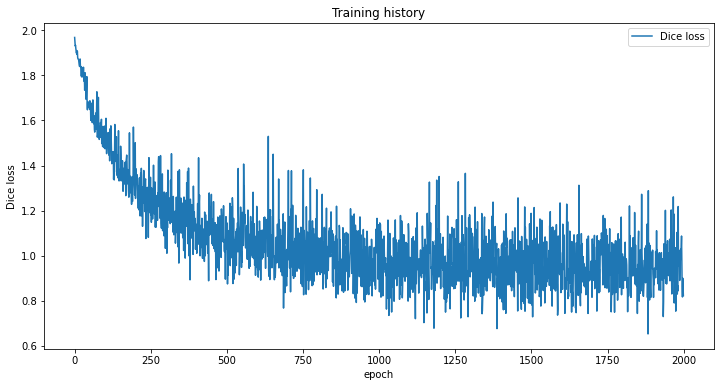


Total computing time:  5 hrs  7 mins 47 secs


In [11]:
# Define path towards directory containing the pre-processed images and labels
path = "data/processed/train"

# Define number of epochs
epochs = 2000

# Define frequency of print statements (i.e. every how many epochs to print training progress)
print_checkpoint = 10

# Define checkpoint (i.e. number of epochs after which the model will be saved)
checkpoint = 500

# Define DataLoader parameters
batch_size = 3
num_workers = 0
pin_memory = False

# Implements data parallelism at the module level
model = torch.nn.DataParallel(model).cuda()

# Generate instance of the loss function
criterion = MultiClassDiceLoss()

# Generate dataset
train = ProcessedDataset(path, rotation=True, warping=True, cropping=True)

# Load dataset
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# Initialize mean epoch loss tracker (-> one mean loss value per epoch)
mean_epoch_loss = []

# Initialize time tracker
start_time = time()

for epoch in range(1, epochs+1):
    
    # Update learning rate decay (will only update by gamma when epoch milestone is reached)
    lr_decay.step()
    
    # Initialize mean sample loss tracker (-> one mean loss value per sample)
    mean_sample_loss = []
    
    # Loop through training samples
    for img, label in train_loader:
        
        img = img.cuda()

        # Pass sample through model
        stage1_output, stage2_output = model(img)
        
        # Calculate sample loss
        loss = criterion(stage1_output, stage2_output, label)
        
        # Append loss to mean sample loss tracker
        mean_sample_loss.append(loss.item())
        
        # Update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Append loss to mean epoch loss tracker
    mean_epoch_loss.append(loss.item())    
    
    # Print update statement for tracking
    if epoch == 1 or epoch%print_checkpoint == 0:
        current_time = time() - start_time
        print(f'\033[1mCompleted epochs:\033[0m {epoch:4.0f}/{epochs} | '
              f'\033[1mDice loss:\033[0m {loss.item():4.3f} | '
              f'\033[1mMean dice score:\033[0m {(2-loss.item())/2:4.3f} | '
              f'\033[1mTime elapsed:\033[0m {current_time//3600:2.0f} hrs '
              f'{(current_time - current_time//3600*3600)//60:2.0f} mins '
              f'{current_time%60:2.0f} secs')

    # Save model every checkpoint
    if epoch%checkpoint == 0:
        #   Define current model state using dictionary
        model_state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        #   Save current model
        torch.save(model_state, 'models/MultiScalePyramid_' + str(epoch) + '.pt')
        # Generate loss history DataFrame
        loss_history = pd.DataFrame(mean_epoch_loss, columns=['Dice loss'])
        # Save loss history
        loss_history.to_csv('history/MultiScalePyramid_' + str(epoch) + '.csv')
        #   Print save statement
        print(f'\n\tCheckpoint -> Model saved at {epoch:4.0f}/{epochs} epochs\n')

# Save final model
#   Define current model state using dictionary
model_state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
#   Save current model
torch.save(model_state, 'models/MultiScalePyramid_' + str(epoch) + '.pt')

# Generate loss history DataFrame
loss_history = pd.DataFrame(mean_epoch_loss, columns=['Dice loss'])

# Save loss history
loss_history.to_csv('history/MultiScalePyramid_' + str(epoch) + '.csv')

# Plot training history
loss_history.plot(figsize=(12,6))
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Dice loss')
plt.title('Training history')
plt.show()

# Print total computing time
total_time = time() - start_time
print(f'\033[1m\nTotal computing time:\033[0m {total_time//3600:2.0f} hrs '
      f'{(total_time - total_time//3600*3600)//60:2.0f} mins '
      f'{total_time%60:2.0f} secs')

___
# Model Evaluation

## Re-load pre-processing parameters

In [9]:
# Distance between frames
interframe_distance = 3

# Zoom factor along the y- and z-axes
yz_zoom_factor = 0.25

# Grayscale threshold
#   -> Sets any value > grayscale_threshold = grayscale_threshold
#   -> Sets any value < -grayscale_threshold = -grayscale_threshold
grayscale_threshold = 350

# Define number of consecutive frames to select out of the images and labels
consecutive_frames = 48

# Define path towards directory containing the pre-processed images and labels
path = "data/processed/train"

# Define DataLoader parameters
batch_size = 3
num_workers = 0
pin_memory = False

# Generate dataset
train = ProcessedDataset(path, rotation=True, warping=True, cropping=True)

# Load dataset
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# Grab the first sample from the DataSet
for i, (img, label) in enumerate(train_loader):
    break

# Model parameters
input_shape = img.shape[3]
num_labels = 13
dropout_rate = 0.3

## Generate predictions and evaluate model
Here are the different evaluation steps:

1. Load the trained model
2. Generate predictions on test images (i.e. images that the model has never seen)
3. Calculate dice score for each label (organ) by comparing the prediction to the original labeled data
4. Save all predictions in a .nii format
5. Save dice results in a .csv table
6. Display dice results

In [14]:
# Define paths towards directories containing the raw images and labels
img_path = "data/raw/test/img"
label_path = "data/raw/test/label"

# Define path towards directory where the predicted labels will be saved
predictions_path = "results/predictions"

# Define path towards directory where the label-specific dice results will be saved
dice_results_path = "results"

# Generate lists containing the filenames of every file contained in the img and label directories
img_files = sorted(os.listdir(img_path))
label_files = sorted(os.listdir(label_path))
files = np.array([img_files, label_files]).transpose()

# Define list of labels
labels_list = ['background/other', 'spleen', 'right kidney', 'left kidney',
               'gallbladder', 'esophagus', 'liver',
               'stomach', 'aorta', 'inferior vena cava',
               'portal vein and splenic vein', 'pancreas',
               'right adrenal gland', 'left adrenal gland']

# Define filename to load trained model
load_filename = 'MultiScalePyramid_2000.pt'

# Re-create instance of the multi-scale pyramid model
model = MultiScalePyramid(training=False)

# Implements data parallelism at the module level
model = torch.nn.DataParallel(model).cuda()

# Load trained model parameters
model_state = torch.load('models/' + load_filename)
epochs = model_state['epoch']
state_dict = model_state['state_dict']

'''
# If error when loading trained model state dictionary, use following code:
# Relabel the state dictionary to prevent error
new_state_dict = OrderedDict()
for k,v in state_dict.items():    
    name = k[7:]
    new_state_dict[name]=v
state_dict = new_state_dict
'''

# Apply trained model parameters to model
model.load_state_dict(state_dict)

# Make sure NO backpropagation happens and the model DOES NOT train
for parameter in model.parameters():
    parameter.requires_grad = False

# Specify that model is in evaluation mode
model.eval()

# Define filename to save dice results
dice_filename = 'dice_results_' + str(epochs) + '.csv'

# Initialize dice results array
dice_results = np.zeros((len(labels_list), len(img_files)))

# Initialize time tracker
start_time = time()

# Display header for upcoming shape check print statement
print('\033[1m\t\tORIGINAL SHAPE\033[0m  |  \033[1mPREDICTION SHAPE\033[0m  |  \033[1mEXPORT STATUS\033[0m')

for i, (img_file, label_file) in enumerate(files, start=1):
    
    # Read images and labels
    img = sitk.ReadImage(os.path.join(img_path, img_file), sitk.sitkInt16)
    label = sitk.ReadImage(os.path.join(label_path, label_file), sitk.sitkInt16)
    
    # Convert images and labels from SimpleITK.Image to numpy.ndarray format
    img_arr = sitk.GetArrayFromImage(img)
    label_arr = sitk.GetArrayFromImage(label)

    # Apply a grayscale filter to remove high intensity values
    img_arr[img_arr>grayscale_threshold] = grayscale_threshold
    img_arr[img_arr<-grayscale_threshold] = -grayscale_threshold

    # Calculate zoom factors
    zoom_factors = (img.GetSpacing()[-1]/interframe_distance, yz_zoom_factor, yz_zoom_factor)
    
    # Use interpolation to normalize spacing between frames
    img_arr = ndimage.zoom(img_arr, zoom_factors, order=3)

    # Initialize slicing parameters
    shape_test = False
    start_slice = 0
    end_slice = start_slice + consecutive_frames - 1
    img_arr_list = []

    # Append img_arr_list with a arrays that contain consecutive_frames number of slices
    # (the model will generate predictions for each set of slices until the whole scan has been segmented)
    while end_slice <= img_arr.shape[0] - 1:
        img_arr_list.append(img_arr[start_slice:end_slice+1,:,:])
        start_slice = end_slice + 1
        end_slice = start_slice + consecutive_frames - 1

    # If the total number of slices (i.e. img_arr.shape[0]) is not a multiple of consecutive_frames,
    # the very last slice will be made of the last consecutive_frames number of slices
    if end_slice != img_arr.shape[0] - 1:
        shape_test = True
        img_arr_list.append(img_arr[-consecutive_frames:,:,:])    

    # Initialize list of predictions
    predictions_list = []

    # Ensure the model is not updated when generating predictions
    with torch.no_grad():

        # Enumerate through list of sliced testing samples
        for img_arr_test in img_arr_list:
            
            # Convert images from numpy.ndarray to torch.FloatTensor format
            img_tensor = torch.FloatTensor(img_arr_test).cuda().unsqueeze(dim=0).unsqueeze(dim=0)

            # Pass sample through model (only available output during testing -> stage2_output)
            stage2_output = model(img_tensor).squeeze()

            # Squeeze output to be 1D
            stage2_output = stage2_output.squeeze()
            
            # Append output to list of predictions
            predictions_list.append(stage2_output.cpu().detach().numpy())
            
            # To prevent memory limitations, each prediction is deleted after being appended
            # to the list of precictions as an array
            del stage2_output
    
    # Concatenate results
    predicted_labels = np.concatenate(predictions_list[0:-1], axis=1)
    if shape_test == False:
        predicted_labels = np.concatenate([predicted_labels, predictions_list[-1]], axis=1)
    else:
        predicted_labels = np.concatenate([predicted_labels,
                                           predictions_list[-1][:, -(img_arr.shape[0] - start_slice):, :, :]],
                                           axis=1)

    # Convert predicted labels from numpy.ndarray to torch.FloatTensor format
    predicted_labels = torch.FloatTensor(predicted_labels).unsqueeze(dim=0)

    # Use linear interpolation to reshape the predicted labels into the same format as the original files
    predicted_labels = F.upsample(predicted_labels, label_arr.shape, mode='trilinear').squeeze().detach().numpy()
    predicted_labels = np.round(np.argmax(predicted_labels, axis=0)).astype(np.uint8)

    # Save shapes of original and predicted labels
    label_arr_shape = label_arr.shape
    predicted_labels_shape = predicted_labels.shape

    # Loop through each organ label and calculate organ-specific dice score
    for label_idx, label_name in enumerate(labels_list):
        
        # Initialize arrays of zeros for organ-specific label and predictions
        target_label = np.zeros(label_arr.shape)
        predicted_label = np.zeros(predicted_labels.shape)

        # Specify what pixels correspond to current labels (original and predicted)
        target_label[label_arr == label_idx] = 1
        predicted_label[predicted_labels == label_idx] = 1

        # Calculate dice score only if the corresponding organ is present
        if target_label.sum() != 0:
            dice = (2*predicted_label*target_label).sum() / (predicted_label.sum()+target_label.sum())
            dice_results[label_idx, i-1] = np.round(dice,3)
        else:
            dice_results[label_idx, i-1] = np.nan
          
    # Convert predicted labels from SimpleITK.Image to numpy.ndarray format
    predicted_labels = sitk.GetImageFromArray(predicted_labels)

    # Set original images properties to predicted labels
    predicted_labels.SetDirection(img.GetDirection())
    predicted_labels.SetOrigin(img.GetOrigin())
    predicted_labels.SetSpacing(img.GetSpacing())

    # Export predicted labels in Nifti (.nii) format
    sitk.WriteImage(predicted_labels, os.path.join(predictions_path, 'predicted_' + label_file[:-3]))

    # Print shapes of original and predicted labels for verification, and confirm export status
    print(f'Sample #{label_file[5:-7]}    {str(label_arr_shape):15} |'
          f'  {str(predicted_labels_shape):15}   |  Predictions generated and exported')

    # To prevent memory limitations, each prediction is deleted after being exported
    del predicted_labels

# Generate dice results dataframe
df_results = pd.DataFrame(dice_results, index=labels_list, columns=[img_file[:7] for img_file in img_files])
df_results['mean'] = np.round(np.nanmean(dice_results, axis=1), 3)
df_results['std'] = np.round(np.nanstd(dice_results, axis=1), 3)

# Export dice results dataframe to csv file
df_results.to_csv(os.path.join(dice_results_path, dice_filename))

# Print total computing time
total_time = time() - start_time
print(f'\033[1m\n\nTotal computing time:\033[0m {total_time//3600:2.0f} hrs '
      f'{(total_time - total_time//3600*3600)//60:2.0f} mins '
      f'{total_time%60:2.0f} secs')

# Display dice results
print('\033[1m\n\nLABEL-SPECIFIC DICE RESULTS ON TESTING DATA\033[0m\n')
df_results

		ORIGINAL SHAPE  |  PREDICTION SHAPE  |  EXPORT STATUS
Sample #0035    (94, 512, 512)  |  (94, 512, 512)    |  Predictions generated and exported
Sample #0036    (184, 512, 512) |  (184, 512, 512)   |  Predictions generated and exported
Sample #0037    (99, 512, 512)  |  (99, 512, 512)    |  Predictions generated and exported
Sample #0038    (100, 512, 512) |  (100, 512, 512)   |  Predictions generated and exported
Sample #0039    (90, 512, 512)  |  (90, 512, 512)    |  Predictions generated and exported
Sample #0040    (195, 512, 512) |  (195, 512, 512)   |  Predictions generated and exported


Total computing time:  0 hrs  1 mins  2 secs


LABEL-SPECIFIC DICE RESULTS ON TESTING DATA



img0035  img0036  img0037  img0038  img0039  \
background/other                0.000    0.000    0.000    0.000    0.000   
spleen                          0.779    0.822    0.699    0.786    0.861   
right kidney                    0.690    0.768    0.766    0.496    0.675   
left kidney                     0.693    0.728    0.836    0.823    0.726   
gallbladder                       NaN    0.316    0.623    0.100    0.616   
esophagus                       0.583    0.429    0.704    0.622    0.537   
liver                           0.870    0.868    0.863    0.774    0.910   
stomach                         0.693    0.667    0.353    0.711    0.738   
aorta                           0.740    0.726    0.828    0.583    0.750   
inferior vena cava              0.664    0.749    0.728    0.608    0.569   
portal vein and splenic vein    0.566    0.422    0.573    0.392    0.488   
pancreas                        0.001    0.001    0.003    0.002    0.001   
right adrenal gland             0.402    0.468    0.576    0.422    0.455   
left adrenal gland              0.441    0.412    0.203    0.370    0.561   

                              img0040   mean    std  
background/other                0.000  0.000  0.000  
spleen                          0.650  0.766  0.072  
right kidney                    0.752  0.691  0.094  
left kidney                     0.868  0.779  0.066  
gallbladder                     0.283  0.388  0.203  
esophagus                       0.421  0.549  0.101  
liver                           0.873  0.860  0.041  
stomach                         0.728  0.648  0.134  
aorta                           0.527  0.692  0.104  
inferior vena cava              0.626  0.657  0.064  
portal vein and splenic vein    0.480  0.487  0.067  
pancreas                        0.001  0.002  0.001  
right adrenal gland             0.525  0.475  0.060  
left adrenal gland              0.528  0.419  0.117

## Display predictions
The code below enables the display of 5 equally distanced frames extracted from the original testing images along with the corresponding target labels (manual segmentation), as well as the corresponding predictions for visual comparison.

LIST OF LABELS
 0 - background/other
 1 - spleen
 2 - right kidney
 3 - left kidney
 4 - gallbladder
 5 - esophagus
 6 - liver
 7 - stomach
 8 - aorta
 9 - inferior vena cava
10 - portal vein and splenic vein
11 - pancreas
12 - right adrenal gland
13 - left adrenal gland


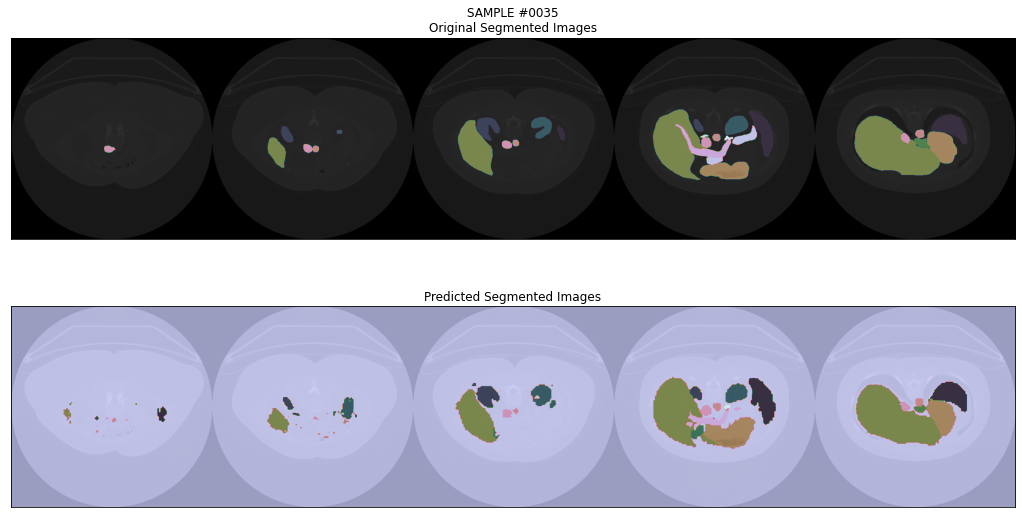

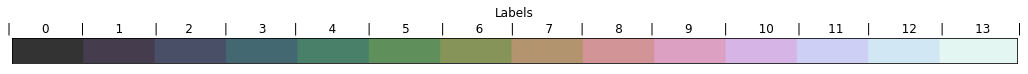

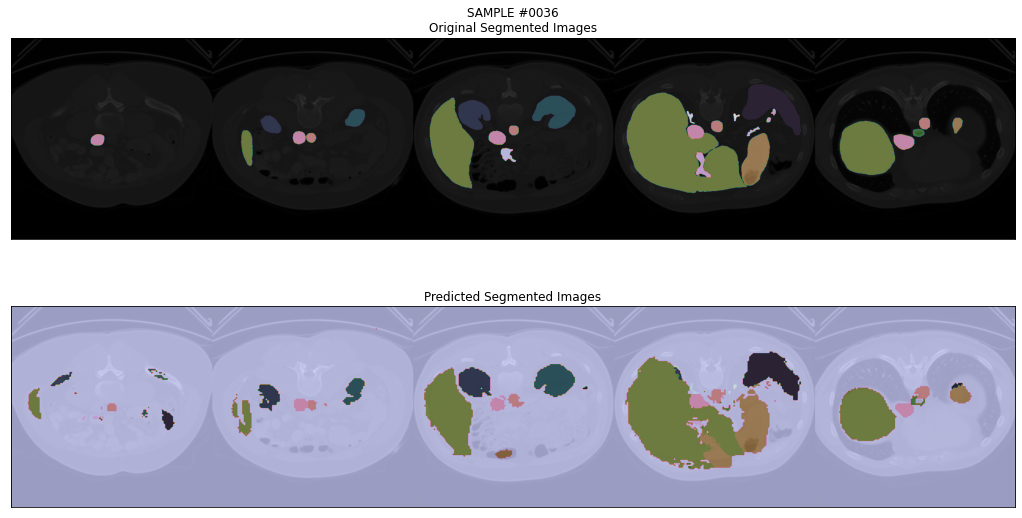

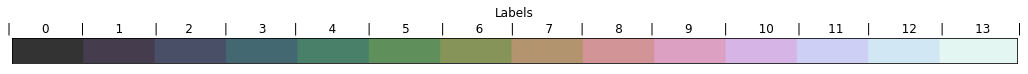

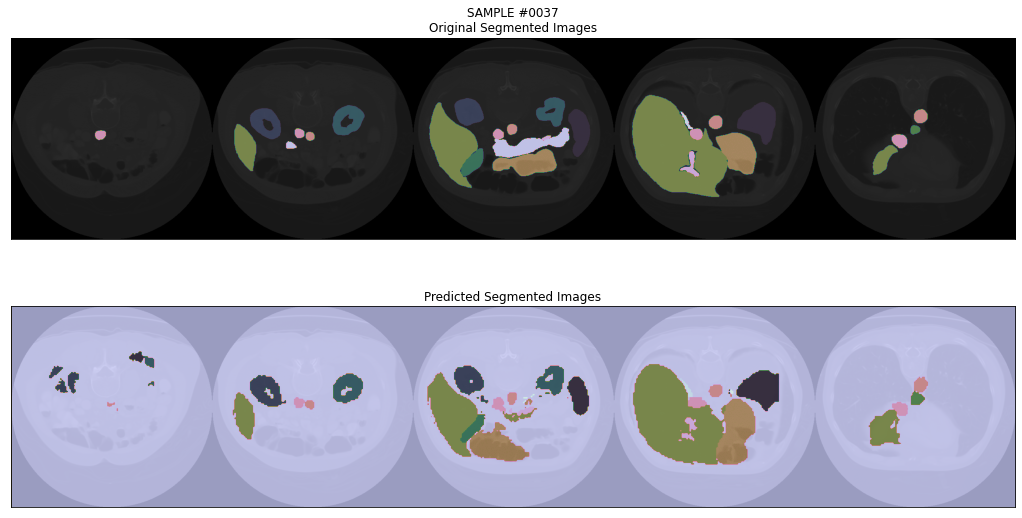

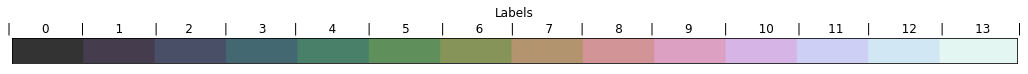

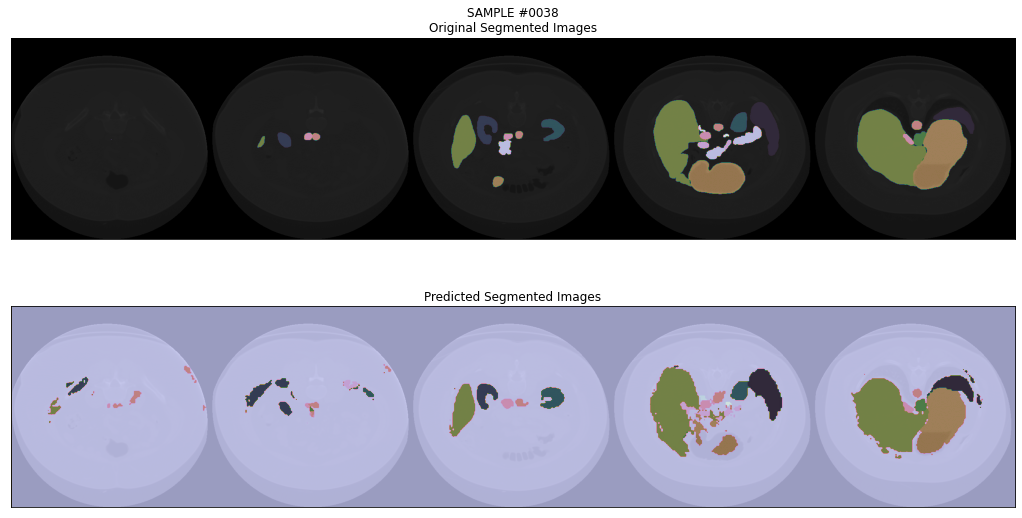

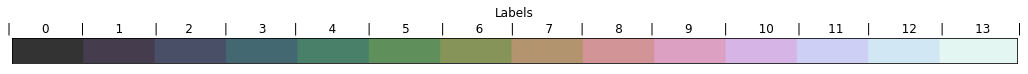

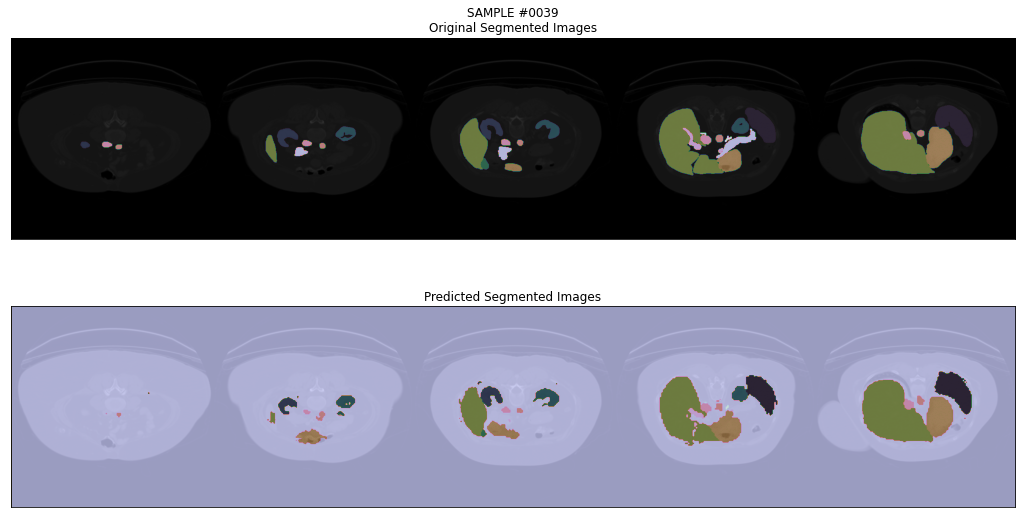

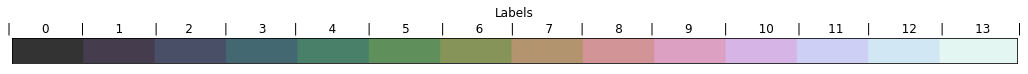

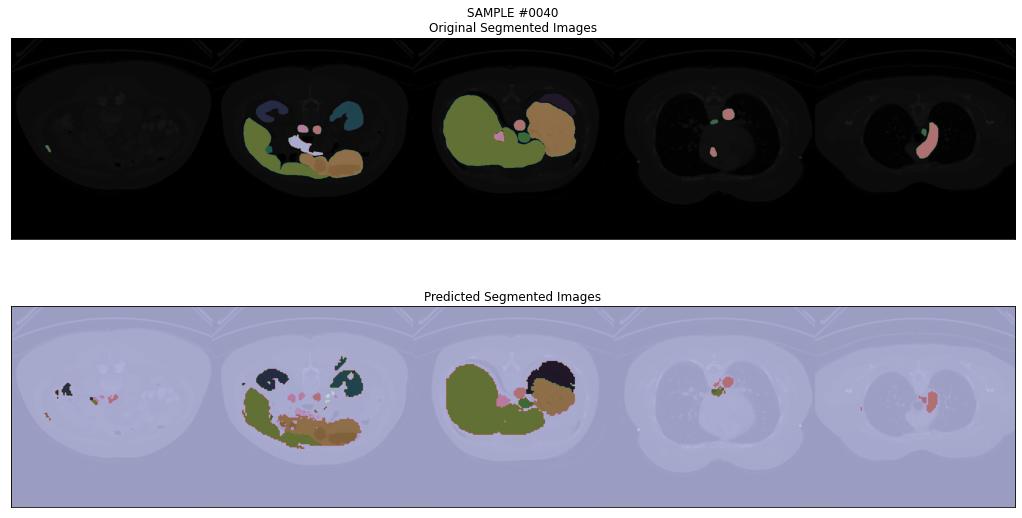

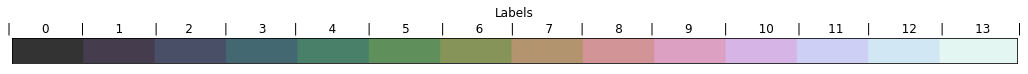

In [15]:
# Define paths towards directories containing the raw images and labels
img_path = "data/raw/test/img"
label_path = "data/raw/test/label"

# Define path towards directory containing the predicted labels
predictions_path = "results/predictions"

# Generate lists containing the filenames of every file contained in the img, label and predictions directories
img_files = sorted(os.listdir(img_path))
label_files = sorted(os.listdir(label_path))
predictions_files = sorted(os.listdir(predictions_path))[1:]

# Generate legend grid to display the colormap and corresponding labels
grid_legend = np.zeros((50, 2000))
col = 1
for g in range(142,14*142,142):
    grid_legend[:len(grid_legend),g:g*2] = col
    col += 1

# Print list of labels indices along with the corresponding labels names
print('LIST OF LABELS')
for label_idx, label in enumerate(labels_list):
    print(f'{label_idx:2.0f} - {label}')

# Loop through all testing data
for i in range(len(img_files)):

    # Read images, labels and predicted labels
    img = sitk.ReadImage(os.path.join(img_path, img_files[i]), sitk.sitkInt16)
    label = sitk.ReadImage(os.path.join(label_path, label_files[i]), sitk.sitkInt16)
    predictions = sitk.ReadImage(os.path.join(predictions_path, predictions_files[i]), sitk.sitkInt16)

    # Convert images, labels and predicted labels from SimpleITK.Image to numpy.ndarray format
    img_arr = sitk.GetArrayFromImage(img)
    label_arr = sitk.GetArrayFromImage(label)
    predictions_arr = sitk.GetArrayFromImage(predictions)

    # Isolate the indices of every frame that contains labeled data
    labeled = []
    for j in range(label_arr.shape[0]):
        if label_arr[j,:,:].max() == 0:
            pass
        else:
            labeled.append(j)

    # Initialize grid arrays with a column vector of zeros
    grid_img = np.zeros((img_arr.shape[1],1))
    grid_label = np.zeros((label_arr.shape[1],1))
    grid_predictions = np.zeros((predictions_arr.shape[1],1))

    # Isolate the indices of 5 evenly distanced labeled frames 
    for k in range(5):  
        frame_idx = labeled[0] + int(img_arr[labeled[0]:].shape[0]/5)*k
        # Stack each new image along the x-axis to generate a grid of 5 stacked images
        grid_img = np.hstack([grid_img, img_arr[frame_idx,:,:]])
        grid_label = np.hstack([grid_label, label_arr[frame_idx,:,:]])
        grid_predictions = np.hstack([grid_predictions, predictions_arr[frame_idx,:,:]])

    # Display grids
    plt.figure(figsize=(18,14))

    plt.subplot(311)
    plt.imshow(grid_img, cmap='gray')
    plt.imshow(grid_label, cmap='cubehelix', alpha=0.8, vmin=0, vmax=14)
    ax = plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.title(f'SAMPLE #{img_files[i][3:7]}\nOriginal Segmented Images')

    plt.subplot(312)
    plt.imshow(grid_img, cmap='gray')
    plt.imshow(grid_predictions, cmap='cubehelix', alpha=0.8, vmin=0, vmax=14)
    ax = plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.title('Predicted Segmented Images')

    plt.figure(figsize=(18,3))
    plt.imshow(grid_legend, cmap='cubehelix', alpha=0.8, vmin=0, vmax=14)
    ax = plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.title('Labels\n|        0        |        1        |       2        |        3       |'
              '        4        |        5        |        6       |        7       |        8       |'
              '        9        |        10      |       11      |        12      |        13       |')

    plt.show()

**OBSERVATIONS**

Most organs seem to be label correctly, but strangely, the background is labeled as the 'pancreas', leading to close to 0% dice scores for 'background/other' and 'pancreas'.
The reason why this is happening is unclear, but let's try to manually correct this by changing the label of every pixel that has a label of 11 (i.e. pancreas) back to zero.

In [19]:
# Define paths towards directories containing the raw images and labels
img_path = "data/raw/test/img"
label_path = "data/raw/test/label"

# Define path towards directory where the predicted labels will be saved
predictions_path = "results/predictions/background_corrected"

# Define path towards directory where the label-specific dice results will be saved
dice_results_path = "results"

# Generate lists containing the filenames of every file contained in the img and label directories
img_files = sorted(os.listdir(img_path))
label_files = sorted(os.listdir(label_path))
files = np.array([img_files, label_files]).transpose()

# Define list of labels
labels_list = ['background/other', 'spleen', 'right kidney', 'left kidney',
               'gallbladder', 'esophagus', 'liver',
               'stomach', 'aorta', 'inferior vena cava',
               'portal vein and splenic vein', 'pancreas',
               'right adrenal gland', 'left adrenal gland']

# Define filename to load trained model
load_filename = 'MultiScalePyramid_2000.pt'

# Re-create instance of the multi-scale pyramid model
model = MultiScalePyramid(training=False)

# Implements data parallelism at the module level
model = torch.nn.DataParallel(model).cuda()

# Load trained model parameters
model_state = torch.load('models/' + load_filename)
epochs = model_state['epoch']
state_dict = model_state['state_dict']

'''
#If error when loading trained model state dictionary, use following code:
# Relabel the state dictionary to prevent error
new_state_dict = OrderedDict()
for k,v in state_dict.items():    
    name = k[7:]
    new_state_dict[name]=v
state_dict = new_state_dict
'''

# Apply trained model parameters to model
model.load_state_dict(state_dict)

# Make sure NO backpropagation happens and the model DOES NOT train
for parameter in model.parameters():
    parameter.requires_grad = False

# Specify that model is in evaluation mode
model.eval()

# Define filename to save dice results
dice_filename = 'dice_results_corrected' + str(epochs) + '.csv'

# Initialize dice results array
dice_results = np.zeros((len(labels_list), len(img_files)))

# Initialize time tracker
start_time = time()

# Display header for upcoming shape check print statement
print('\033[1m\t\tORIGINAL SHAPE\033[0m  |  \033[1mPREDICTION SHAPE\033[0m  |  \033[1mEXPORT STATUS\033[0m')

for i, (img_file, label_file) in enumerate(files, start=1):
    
    # Read images and labels
    img = sitk.ReadImage(os.path.join(img_path, img_file), sitk.sitkInt16)
    label = sitk.ReadImage(os.path.join(label_path, label_file), sitk.sitkInt16)
    
    # Convert images and labels from SimpleITK.Image to numpy.ndarray format
    img_arr = sitk.GetArrayFromImage(img)
    label_arr = sitk.GetArrayFromImage(label)

    # Apply a grayscale filter to remove high intensity values
    img_arr[img_arr>grayscale_threshold] = grayscale_threshold
    img_arr[img_arr<-grayscale_threshold] = -grayscale_threshold

    # Calculate zoom factors
    zoom_factors = (img.GetSpacing()[-1]/interframe_distance, yz_zoom_factor, yz_zoom_factor)
    
    # Use interpolation to normalize spacing between frames
    img_arr = ndimage.zoom(img_arr, zoom_factors, order=3)

    # Initialize slicing parameters
    shape_test = False
    start_slice = 0
    end_slice = start_slice + consecutive_frames - 1
    img_arr_list = []

    # Append img_arr_list with a arrays that contain consecutive_frames number of slices
    # (the model will generate predictions for each set of slices until the whole scan has been segmented)
    while end_slice <= img_arr.shape[0] - 1:
        img_arr_list.append(img_arr[start_slice:end_slice+1,:,:])
        start_slice = end_slice + 1
        end_slice = start_slice + consecutive_frames - 1

    # If the total number of slices (i.e. img_arr.shape[0]) is not a multiple of consecutive_frames,
    # the very last slice will be made of the last consecutive_frames number of slices
    if end_slice != img_arr.shape[0] - 1:
        shape_test = True
        img_arr_list.append(img_arr[-consecutive_frames:,:,:])    

    # Initialize list of predictions
    predictions_list = []

    # Ensure the model is not updated when generating predictions
    with torch.no_grad():

        # Enumerate through list of sliced testing samples
        for img_arr_test in img_arr_list:
            
            # Convert images from numpy.ndarray to torch.FloatTensor format
            img_tensor = torch.FloatTensor(img_arr_test).cuda().unsqueeze(dim=0).unsqueeze(dim=0)

            # Pass sample through model (only available output during testing -> stage2_output)
            stage2_output = model(img_tensor).squeeze()

            # Squeeze output to be 1D
            stage2_output = stage2_output.squeeze()
            
            # Append output to list of predictions
            predictions_list.append(stage2_output.cpu().detach().numpy())
            
            # To prevent memory limitations, each prediction is deleted after being appended
            # to the list of precictions as an array
            del stage2_output

    # Concatenate results
    predicted_labels = np.concatenate(predictions_list[0:-1], axis=1)
    if shape_test == False:
        predicted_labels = np.concatenate([predicted_labels, predictions_list[-1]], axis=1)
    else:
        predicted_labels = np.concatenate([predicted_labels,
                                           predictions_list[-1][:, -(img_arr.shape[0] - start_slice):, :, :]],
                                           axis=1)

    # Convert predicted labels from numpy.ndarray to torch.FloatTensor format
    predicted_labels = torch.FloatTensor(predicted_labels).unsqueeze(dim=0)

    # Use linear interpolation to reshape the predicted labels into the same format as the original files
    predicted_labels = F.upsample(predicted_labels, label_arr.shape, mode='trilinear').squeeze().detach().numpy()
    predicted_labels = np.round(np.argmax(predicted_labels, axis=0)).astype(np.uint8)

    # Correct background by changing the value of every pixel labeled as 2 back to 0
    predicted_labels[predicted_labels==11] = 0

    # Save shapes of original and predicted labels
    label_arr_shape = label_arr.shape
    predicted_labels_shape = predicted_labels.shape

    # Loop through each organ label and calculate organ-specific dice score
    for label_idx, label_name in enumerate(labels_list):
        
        # Initialize arrays of zeros for organ-specific label and predictions
        target_label = np.zeros(label_arr.shape)
        predicted_label = np.zeros(predicted_labels.shape)

        # Specify what pixels correspond to current labels (original and predicted)
        target_label[label_arr == label_idx] = 1
        predicted_label[predicted_labels == label_idx] = 1

        # Calculate dice score only if the corresponding organ is present
        if target_label.sum() != 0:
            dice = (2*predicted_label*target_label).sum() / (predicted_label.sum()+target_label.sum())
            dice_results[label_idx, i-1] = np.round(dice,3)
        else:
            dice_results[label_idx, i-1] = np.nan
          
    # Convert predicted labels from SimpleITK.Image to numpy.ndarray format
    predicted_labels = sitk.GetImageFromArray(predicted_labels)

    # Set original images properties to predicted labels
    predicted_labels.SetDirection(img.GetDirection())
    predicted_labels.SetOrigin(img.GetOrigin())
    predicted_labels.SetSpacing(img.GetSpacing())

    # Export predicted labels in Nifti (.nii) format
    sitk.WriteImage(predicted_labels, os.path.join(predictions_path, 'predicted_corrected_' + label_file[:-3]))

    # Print shapes of original and predicted labels for verification, and confirm export status
    print(f'Sample #{label_file[5:-7]}    {str(label_arr_shape):15} |'
          f'  {str(predicted_labels_shape):15}   |  Predictions generated and exported')

    # To prevent memory limitations, each prediction is deleted after being exported
    del predicted_labels

# Generate dice results dataframe
df_results = pd.DataFrame(dice_results, index=labels_list, columns=[img_file[:7] for img_file in img_files])
df_results['mean'] = np.round(np.nanmean(dice_results, axis=1), 3)
df_results['std'] = np.round(np.nanstd(dice_results, axis=1), 3)

# Export dice results dataframe to csv file
df_results.to_csv(os.path.join(dice_results_path, dice_filename))

# Print total computing time
total_time = time() - start_time
print(f'\033[1m\n\nTotal computing time:\033[0m {total_time//3600:2.0f} hrs '
      f'{(total_time - total_time//3600*3600)//60:2.0f} mins '
      f'{total_time%60:2.0f} secs')

# Display dice results
print('\033[1m\n\nLABEL-SPECIFIC DICE RESULTS ON TESTING DATA\033[0m\n')
df_results

		ORIGINAL SHAPE  |  PREDICTION SHAPE  |  EXPORT STATUS
Sample #0035    (94, 512, 512)  |  (94, 512, 512)    |  Predictions generated and exported
Sample #0036    (184, 512, 512) |  (184, 512, 512)   |  Predictions generated and exported
Sample #0037    (99, 512, 512)  |  (99, 512, 512)    |  Predictions generated and exported
Sample #0038    (100, 512, 512) |  (100, 512, 512)   |  Predictions generated and exported
Sample #0039    (90, 512, 512)  |  (90, 512, 512)    |  Predictions generated and exported
Sample #0040    (195, 512, 512) |  (195, 512, 512)   |  Predictions generated and exported


Total computing time:  0 hrs  1 mins  5 secs


LABEL-SPECIFIC DICE RESULTS ON TESTING DATA



img0035  img0036  img0037  img0038  img0039  \
background/other                0.994    0.989    0.989    0.988    0.995   
spleen                          0.779    0.822    0.699    0.786    0.861   
right kidney                    0.690    0.768    0.766    0.496    0.675   
left kidney                     0.693    0.728    0.836    0.823    0.726   
gallbladder                       NaN    0.316    0.623    0.100    0.616   
esophagus                       0.583    0.429    0.704    0.622    0.537   
liver                           0.870    0.868    0.863    0.774    0.910   
stomach                         0.693    0.667    0.353    0.711    0.738   
aorta                           0.740    0.726    0.828    0.583    0.750   
inferior vena cava              0.664    0.749    0.728    0.608    0.569   
portal vein and splenic vein    0.566    0.422    0.573    0.392    0.488   
pancreas                        0.000    0.000    0.000    0.000    0.000   
right adrenal gland             0.402    0.468    0.576    0.422    0.455   
left adrenal gland              0.441    0.412    0.203    0.370    0.561   

                              img0040   mean    std  
background/other                0.993  0.991  0.003  
spleen                          0.650  0.766  0.072  
right kidney                    0.752  0.691  0.094  
left kidney                     0.868  0.779  0.066  
gallbladder                     0.283  0.388  0.203  
esophagus                       0.421  0.549  0.101  
liver                           0.873  0.860  0.041  
stomach                         0.728  0.648  0.134  
aorta                           0.527  0.692  0.104  
inferior vena cava              0.626  0.657  0.064  
portal vein and splenic vein    0.480  0.487  0.067  
pancreas                        0.000  0.000  0.000  
right adrenal gland             0.525  0.475  0.060  
left adrenal gland              0.528  0.419  0.117

## Display predictions
The code below enables the display of 5 equally distanced frames extracted from the original testing images along with the corresponding target labels (manual segmentation), as well as the corresponding predictions for visual comparison.

LIST OF LABELS
 0 - background/other
 1 - spleen
 2 - right kidney
 3 - left kidney
 4 - gallbladder
 5 - esophagus
 6 - liver
 7 - stomach
 8 - aorta
 9 - inferior vena cava
10 - portal vein and splenic vein
11 - pancreas
12 - right adrenal gland
13 - left adrenal gland


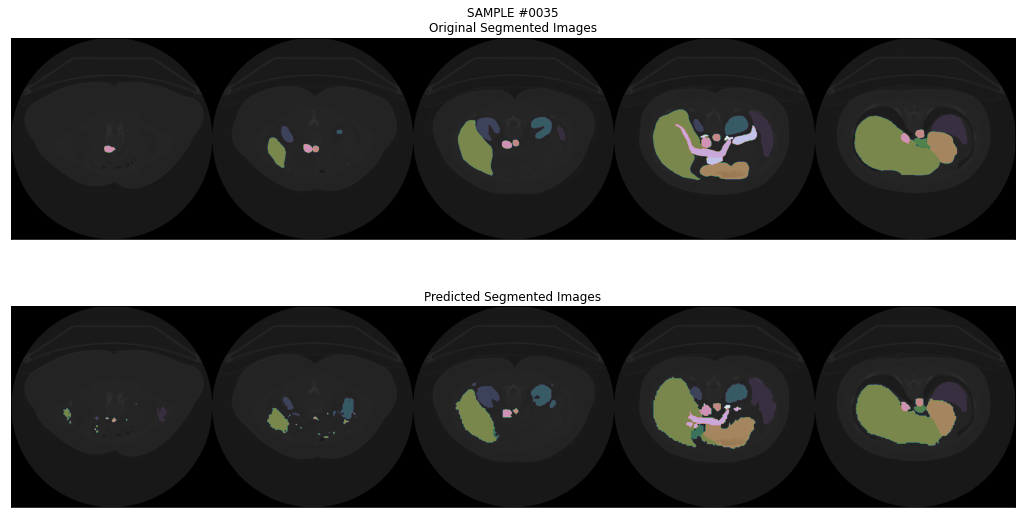

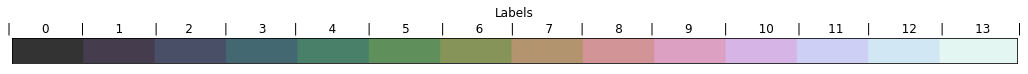

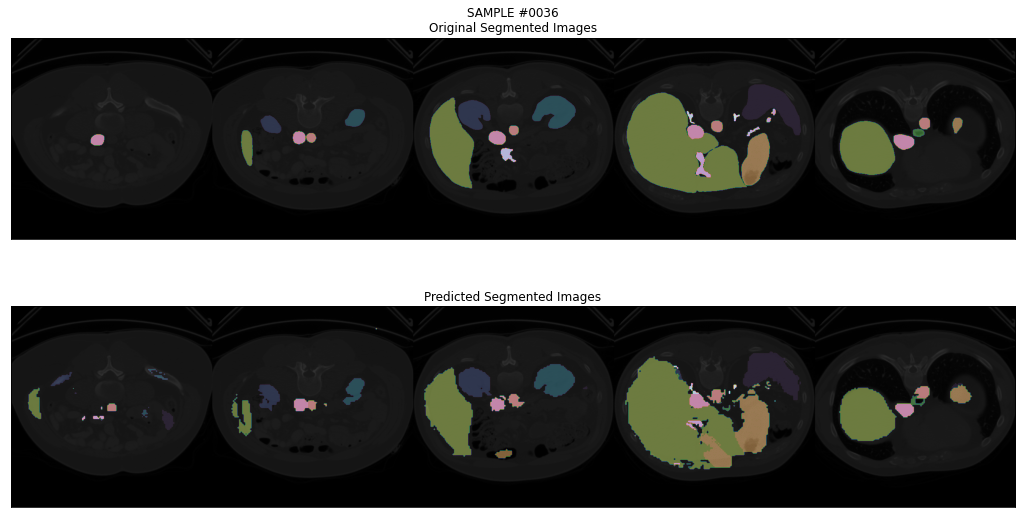

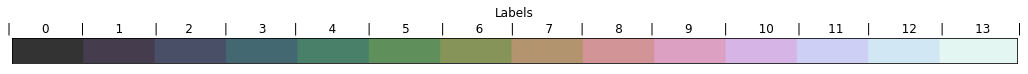

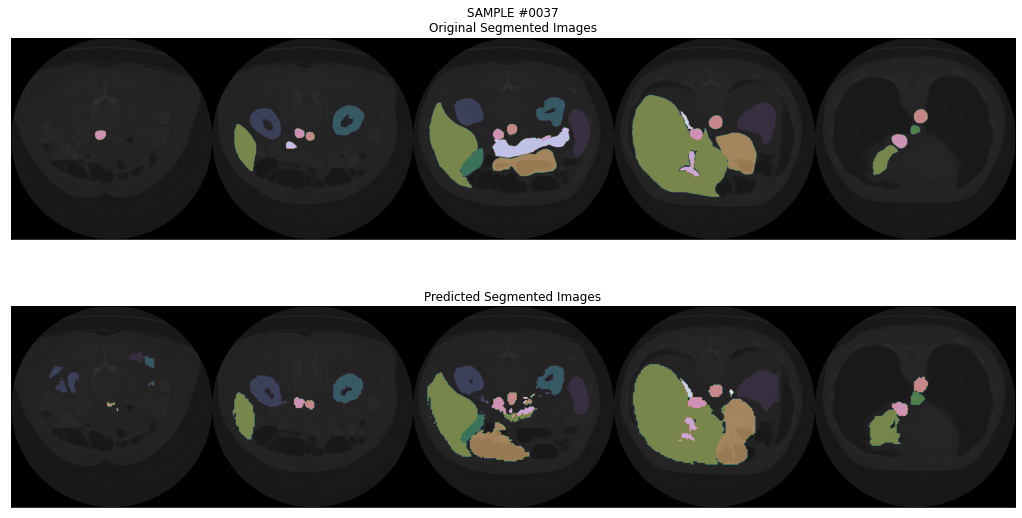

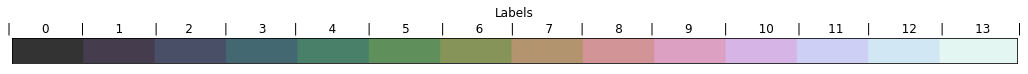

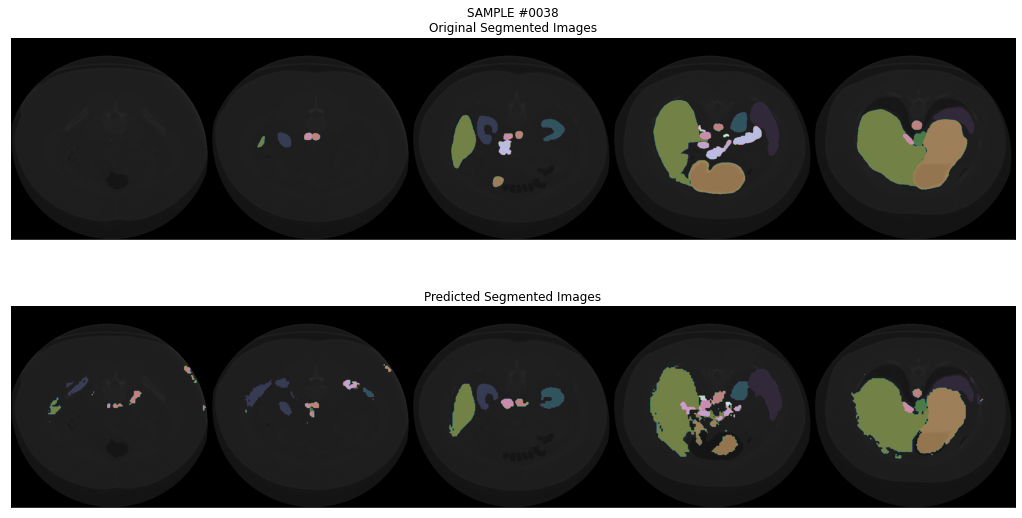

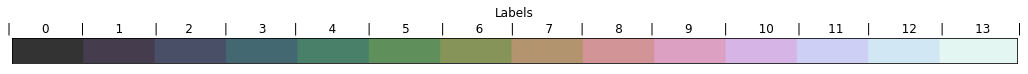

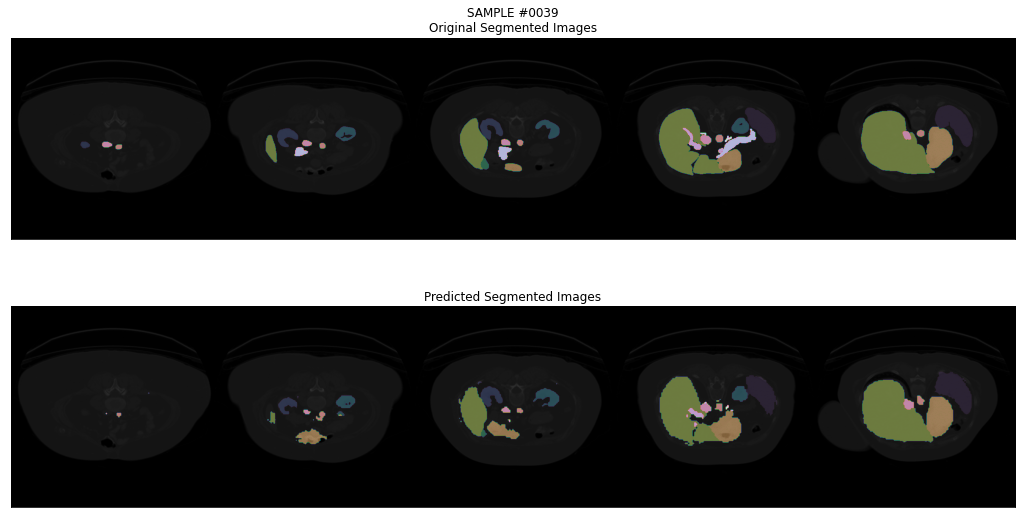

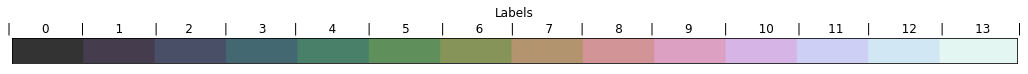

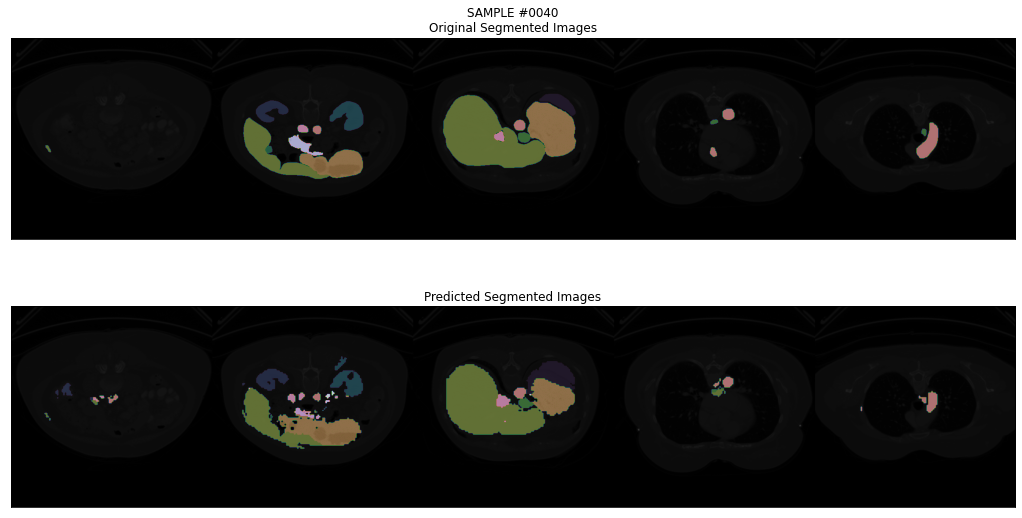

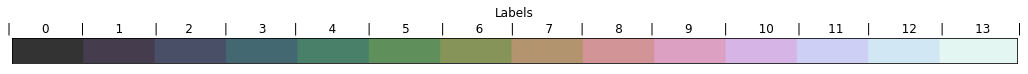

In [20]:
# Define paths towards directories containing the raw images and labels
img_path = "data/raw/test/img"
label_path = "data/raw/test/label"

# Define path towards directory containing the predicted labels
predictions_path = "results/predictions/background_corrected"

# Generate lists containing the filenames of every file contained in the img, label and predictions directories
img_files = sorted(os.listdir(img_path))
label_files = sorted(os.listdir(label_path))
predictions_files = sorted(os.listdir(predictions_path))

# Generate legend grid to display the colormap and corresponding labels
grid_legend = np.zeros((50, 2000))
col = 1
for g in range(142,14*142,142):
    grid_legend[:len(grid_legend),g:g*2] = col
    col += 1

# Print list of labels indices along with the corresponding labels names
print('LIST OF LABELS')
for label_idx, label in enumerate(labels_list):
    print(f'{label_idx:2.0f} - {label}')

# Loop through all testing data
for i in range(len(img_files)):

    # Read images, labels and predicted labels
    img = sitk.ReadImage(os.path.join(img_path, img_files[i]), sitk.sitkInt16)
    label = sitk.ReadImage(os.path.join(label_path, label_files[i]), sitk.sitkInt16)
    predictions = sitk.ReadImage(os.path.join(predictions_path, predictions_files[i]), sitk.sitkInt16)

    # Convert images, labels and predicted labels from SimpleITK.Image to numpy.ndarray format
    img_arr = sitk.GetArrayFromImage(img)
    label_arr = sitk.GetArrayFromImage(label)
    predictions_arr = sitk.GetArrayFromImage(predictions)

    # Isolate the indices of every frame that contains labeled data
    labeled = []
    for j in range(label_arr.shape[0]):
        if label_arr[j,:,:].max() == 0:
            pass
        else:
            labeled.append(j)

    # Initialize grid arrays with a column vector of zeros
    grid_img = np.zeros((img_arr.shape[1],1))
    grid_label = np.zeros((label_arr.shape[1],1))
    grid_predictions = np.zeros((predictions_arr.shape[1],1))

    # Isolate the indices of 5 evenly distanced labeled frames 
    for k in range(5):  
        frame_idx = labeled[0] + int(img_arr[labeled[0]:].shape[0]/5)*k
        # Stack each new image along the x-axis to generate a grid of 5 stacked images
        grid_img = np.hstack([grid_img, img_arr[frame_idx,:,:]])
        grid_label = np.hstack([grid_label, label_arr[frame_idx,:,:]])
        grid_predictions = np.hstack([grid_predictions, predictions_arr[frame_idx,:,:]])

    # Display grids
    plt.figure(figsize=(18,14))

    plt.subplot(311)
    plt.imshow(grid_img, cmap='gray')
    plt.imshow(grid_label, cmap='cubehelix', alpha=0.8, vmin=0, vmax=14)
    ax = plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.title(f'SAMPLE #{img_files[i][3:7]}\nOriginal Segmented Images')

    plt.subplot(312)
    plt.imshow(grid_img, cmap='gray')
    plt.imshow(grid_predictions, cmap='cubehelix', alpha=0.8, vmin=0, vmax=14)
    ax = plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.title('Predicted Segmented Images')

    plt.figure(figsize=(18,3))
    plt.imshow(grid_legend, cmap='cubehelix', alpha=0.8, vmin=0, vmax=14)
    ax = plt.gca()
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.title('Labels\n|        0        |        1        |       2        |        3       |'
              '        4        |        5        |        6       |        7       |        8       |'
              '        9        |        10      |       11      |        12      |        13       |')

    plt.show()

___
# Conclusion
The model performed well for most organs (spleen, right and left kidneys, liver, stomach, aorta and inferior vena cava) with a mean dice score between 64% and 86%, while the remaining organs (esophagus, gallbladder, portal vein and splenic vein, right and left adrenal glands) appeared more challenging to segment (mean dice score: 38% to 55%).

The reason why the model predicted 'pancreas' for the background is yet unclear and requires to be further explored.

Considering the complexity of the data (i.e. unbalanced, large number of organs with very different shapes and sizes, small sample size), the model was still able to detect patterns and provide descent and realistic segmentation results.

Additional research such as trying different/additional augmentation strategies, loss functions or model architectures and performing tests on a larger sample size could help improve the performance of the model.